In [1]:
from itertools import chain
import logging
import numpy as np
from pathlib import Path
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf, open_dict
from typing import Dict, List, Tuple, Any, Optional
import copy
import warnings 
import time
import yaml

import torch
import torch.cuda.amp as amp
from torch import Tensor, nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
from torch.distributions.categorical import Categorical
from torch.nn.utils import clip_grad_value_
from torch.nn.parallel import DistributedDataParallel
from torchvision.transforms import Resize
import os
import torch
import numbers
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.datasets import CIFAR10, Cityscapes
import importlib

import matplotlib.pyplot as plt
import PIL
import os
import diffusers
from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import make_grid, save_image
from torchvision import transforms
from tqdm import trange

In [2]:
### IMAGENET
%load_ext autoreload
%autoreload 2

from ddpm.datasets.imagenet import Imagenet_Dataset
from ddpm.datasets.celeba import CelebA 

from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
from ddpm.model import UNet
from ddpm.ddib_model import UNetModel
from ddpm.ddib_diffusion import GaussianDiffusion, SpacedDiffusion, _extract_into_tensor, space_timesteps, LossType, ModelMeanType, ModelVarType, get_named_beta_schedule

from ddpm.datasets.corruptions import *
from torchvision.transforms import Resize, ToTensor, ToPILImage

In [3]:
from diffusers import UNet2DModel, DDIMScheduler, VQModel, DDIMInverseScheduler
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline,DiffusionPipeline
from diffusers import LDMPipeline

# load model and scheduler
pipe = LDMPipeline.from_pretrained("CompVis/ldm-celebahq-256")
scheduler = pipe.scheduler
vqvae = pipe.vqvae
unet = pipe.unet
# run pipeline in inference (sample random noise and denoise)
image = pipe().images[0]

vqvae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/50 [00:00<?, ?it/s]

In [4]:
device = "cuda:2"
vqvae = pipe.vqvae.to(device)
unet = pipe.unet.to(device)

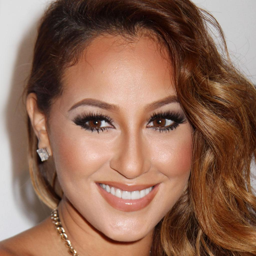

In [5]:
img = PIL.Image.open("/mnt/scitas/bastien/CelebAMask-HQ/CelebA-HQ-img/1003.jpg").resize([256,256])
# img = PIL.Image.open("/home/bastienvandelft/digiface1m_subject_0/0/0.png").resize([256,256])
img = img.convert('RGB')
img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


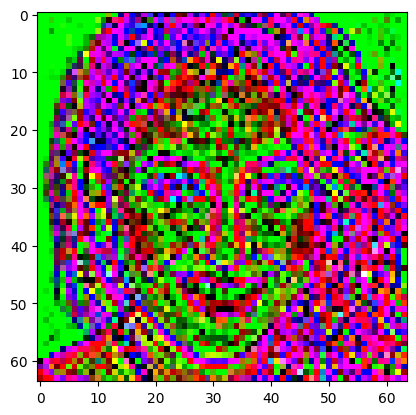

In [6]:
from torchvision.transforms import Resize, ToTensor, ToPILImage
img_tensor = (torch.from_numpy(np.array(img)).permute(2,0,1)/255)*2-1
latent = vqvae.quantize(vqvae.encode(img_tensor.unsqueeze(0).to(device))[0])[0]
plt.imshow(latent.squeeze(0).data.cpu().permute(1,2,0))

In [63]:
vqvae.quantize(vqvae.encode(clipped_decoded)[0])[0] == vqvae.encode(clipped_decoded)[0]

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


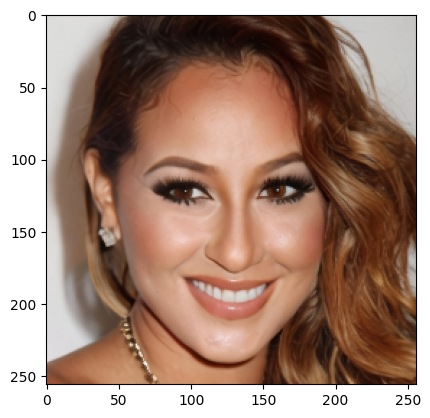

In [7]:
decoded_latent = vqvae.decode(latent)[0]
clipped_decoded = decoded_latent.clamp(-1,1)
reencoded = vqvae.quantize(vqvae.encode(clipped_decoded)[0])[0]
decoded_latent_2 = vqvae.decode(reencoded)[0]
plt.imshow(decoded_latent_2.squeeze(0).data.cpu().permute(1,2,0) /2 + 0.5)

In [13]:
### Corrupting input
# to_image = ToPILImage()
# target_image = to_image(img_tensor)
# pil_input_image = to_image(((inputs + 1) * 127.5).clamp(0, 255).to(torch.uint8))
# sample_targets = (((targets + 1) * 127.5).clamp(0.255).to(torch.uint8).permute(1,2,0).cpu().detach()) / 255
# sample = PIL.Image.fromarray(masking_random_color(img, severity  = 3).astype(np.uint8))
# input_tensor = (torch.from_numpy(np.array(sample)).permute(2,0,1)/255)*2-1

In [8]:
n_steps = 25
scheduler.set_timesteps(num_inference_steps=n_steps)
timesteps_respacing = f"ddim{n_steps}"
model_var_type = ModelVarType.FIXED_SMALL
model_mean_type = ModelMeanType.EPSILON
loss_type = LossType.MSE
spaced_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(1000, timesteps_respacing),
                        betas=scheduler.betas,
                        model_mean_type=model_mean_type,
                        model_var_type=model_var_type,
                        loss_type=loss_type,
                        rescale_timesteps=False,
                        )
spaced_diffusion.not_hugginface = False

In [73]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)
    
    
def reverse_sampling_latent(image, diffusion, vqvae, model, device = None, progress = True):
    if device is None:
        device = next(model.parameters()).device
    shape = image.shape
    indices = list(range(diffusion.num_timesteps))

    if progress:
        # Lazy import so that we don't depend on tqdm.
        from tqdm.auto import tqdm

        indices = tqdm(indices)

    for i in indices:
        t = torch.tensor([i] * shape[0], device=device)
        with torch.no_grad():

            out = diffusion.p_mean_variance(
            model,
            image,
            t,
            clip_denoised=False,
            clip_value=3.,
            denoised_fn=None,
            model_kwargs=None,
        )
 
            decoded_output = vqvae.decode(out["pred_xstart"])[0]
            clipped_output = decoded_output.clamp(-2,2)
            pred_xstart = vqvae.encode(clipped_output)[0]
            # pred_xstart = vqvae.quantize(vqvae.encode(clipped_output)[0])[0]
            out['pred_xstart'] = pred_xstart

            eps = (
                  _extract_into_tensor(diffusion.sqrt_recip_alphas_cumprod, t, image.shape) * image
                  - pred_xstart ) / _extract_into_tensor(diffusion.sqrt_recipm1_alphas_cumprod, t, image.shape)
                
            alpha_bar_next = _extract_into_tensor(diffusion.alphas_cumprod_next, t, image.shape)
            mean_pred = pred_xstart * torch.sqrt(alpha_bar_next) \
                        + torch.sqrt(1 - alpha_bar_next) * eps
    
            out['sample'] = mean_pred
            yield out
            image = out["sample"]

def new_ddim_sampling_loop(diffusion, vqvae, model, shape, noise = None,  device = None, progress = True, starting_t = -1, eta = 0.):
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            image = noise.to(device)
        else:
            image = torch.randn(*shape, device=device)
        if starting_t > 0 :
            starting_t = min(starting_t,diffusion.num_timesteps-1)
            indices = list(range(starting_t+1))[::-1]
        else:
            starting_t = diffusion.num_timesteps
            indices = list(range(diffusion.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)

        for i in indices:
            t = torch.tensor([i] * shape[0], device=device)
            with torch.no_grad():
                out = diffusion.p_mean_variance(
                        model,
                        image,
                        t,
                        clip_denoised=False,
                        clip_value=4.,
                        denoised_fn=None,
                        model_kwargs=None,
                    )
        
                # Usually our model outputs epsilon, but we re-derive it
                # in case we used x_start or x_prev prediction.

                decoded_output = vqvae.decode(out["pred_xstart"])[0]
                clipped_output = decoded_output.clamp(-2,2)
                pred_xstart = vqvae.encode(clipped_output)[0]
                # pred_xstart = vqvae.quantize(vqvae.encode(clipped_output)[0])[0]
                out['pred_xstart'] = pred_xstart
                
                eps = diffusion._predict_eps_from_xstart(image, t, out["pred_xstart"])
                
                alpha_bar = _extract_into_tensor(diffusion.alphas_cumprod, t, image.shape)
                alpha_bar_prev = _extract_into_tensor(diffusion.alphas_cumprod_prev, t, image.shape)
                sigma = (
                        eta
                        * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
                        * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
                )
                # Equation 12.
                noise = torch.randn_like(image)
                mean_pred = (
                        out["pred_xstart"] * torch.sqrt(alpha_bar_prev)
                        + torch.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
                )
                nonzero_mask = (
                    (t != 0).float().view(-1, *([1] * (len(image.shape) - 1)))
                )  # no noise when t == 0
                sample = mean_pred + nonzero_mask * sigma * noise
                out = {"sample": sample, "pred_xstart": out["pred_xstart"], "attention_maps":out["attention_maps"]}
                yield out
                image = out["sample"]
                

In [74]:
def EncodingInput(inputs, diffusion, net_model, device):
    reversing_inputs = inputs.to(device) 
    reverse_encoding = diffusion.ddim_reverse_sample_loop_progressive(net_model,reversing_inputs,
                                                                                 clip_denoised=False, eta=0.)
    ddpm_of_reencoded_tensor = []
    with torch.no_grad():
        for dic in tqdm(reverse_encoding):
            ddpm_of_reencoded_tensor.append(dic['sample'].cpu())
    
    seed = ddpm_of_reencoded_tensor
    return seed

def ODEdit(encoded_inputs ,diffusion,  net_model, number_of_sample, K, langevin_step,temperature, epsilon, starting_t, device):
    seed = encoded_inputs.to(device)
    ddpm_imagenet_sample = diffusion.ddim_sample_loop_progressive(net_model,[number_of_sample,3,64,64], 
                          clip_denoised=True,noise=seed.repeat(number_of_sample,1,1,1),eta = 0., langevin=True,add_noise=True,
                                                                  temperature=temperature, epsilon=epsilon, K=K, 
                                                                         langevin_step = langevin_step, 
                                                                  clip_distance=0., starting_t=starting_t)
    ddpm_of_post_resampled_tensor = []
    with torch.no_grad():
        for dic in tqdm(ddpm_imagenet_sample):
            ddpm_of_post_resampled_tensor.append(dic['sample'].cpu())
    return ddpm_of_post_resampled_tensor[-1]

In [83]:
reversing_inputs = latent.to(device)
reverse_encoding = reverse_sampling_latent(reversing_inputs, spaced_diffusion, vqvae, unet)
ddim_of_reencoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddim_of_reencoded_tensor.append(dic['sample'].cpu())
starting_t = -1   
ddim_sample = new_ddim_sampling_loop(spaced_diffusion, vqvae, unet, shape = [1,3,256,256], noise = ddim_of_reencoded_tensor[starting_t-1],  
                                     device = device, starting_t = starting_t)
ddim_of_resampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddim_sample):
        ddim_of_resampled_tensor.append(dic['sample'].cpu())

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

25it [00:02, 10.91it/s]
0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

25it [00:02, 11.01it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


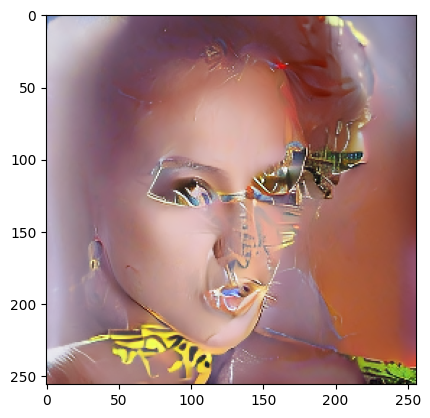

In [84]:
plt.imshow(vqvae.decode(ddim_of_resampled_tensor[-1].to(device))[0].squeeze(0).detach().cpu().permute(1,2,0)/2+0.5)

In [ ]:
##### plt.imshow(ddim_of_reencoded_tensor[2].squeeze(0).detach().cpu().permute(1,2,0)/2+0.5)

In [26]:
### Test Encoding

reversing_inputs = latent.to(device)

reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(unet,reversing_inputs,
                                                                             clip_denoised=True,clip_value=1.5)
ddpm_of_reencoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_reencoded_tensor.append(dic['sample'].cpu())



ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(unet,[1,3,256,256], 
                                                clip_denoised=True,clip_value=1.5,noise=ddpm_of_reencoded_tensor[-1].to(device))
ddpm_of_resampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_resampled_tensor.append(dic['sample'].cpu())

200it [00:05, 36.45it/s]
200it [00:05, 36.39it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


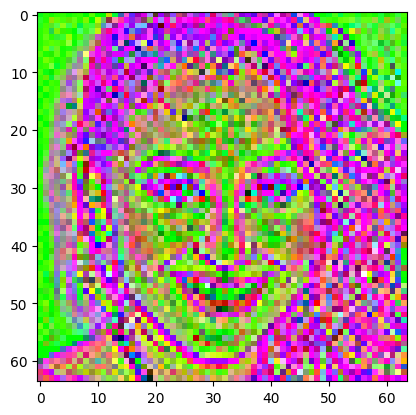

In [27]:
plt.imshow(ddpm_of_resampled_tensor[-1].squeeze(0).detach().cpu().permute(1,2,0)/2+0.5)

In [14]:
inputs =  img_tensor.cuda(3)
encoded_inputs = EncodingInput(inputs, spaced_diffusion, unet)

200it [00:10, 18.39it/s]


200it [00:05, 36.59it/s]
9it [00:00, 36.14it/s]


Step 9 ; Error 0.02163578011095524


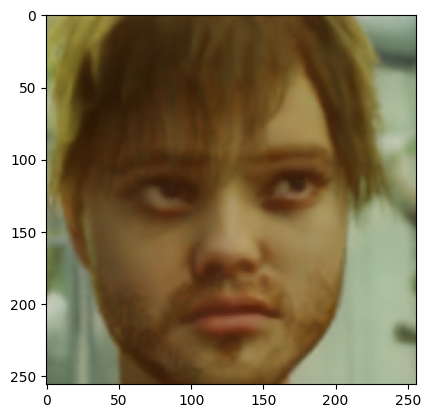

19it [00:00, 36.19it/s]


Step 19 ; Error 0.02275841496884823


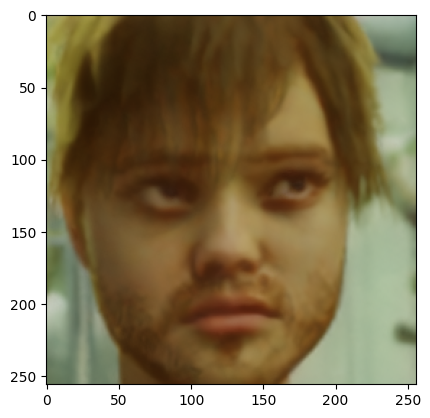

29it [00:00, 36.51it/s]


Step 29 ; Error 0.023485520854592323


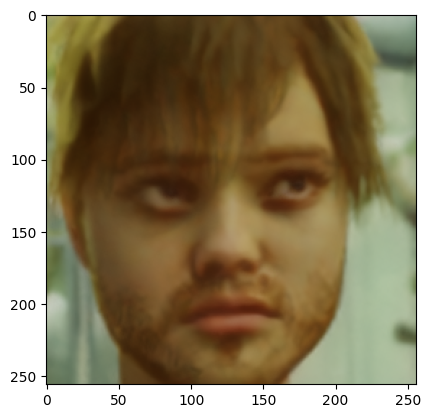

39it [00:01, 36.61it/s]


Step 39 ; Error 0.024182306602597237


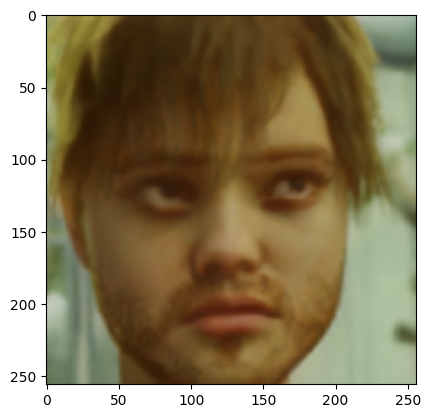

49it [00:01, 36.24it/s]


Step 49 ; Error 0.024979479610919952


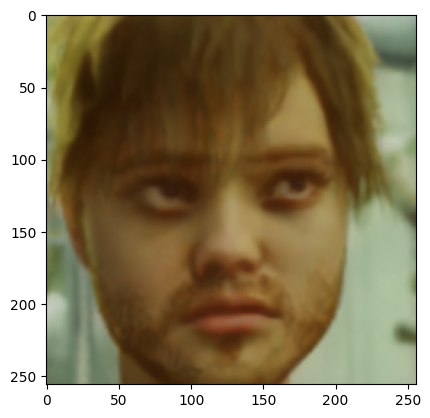

59it [00:01, 36.56it/s]


Step 59 ; Error 0.02589879184961319


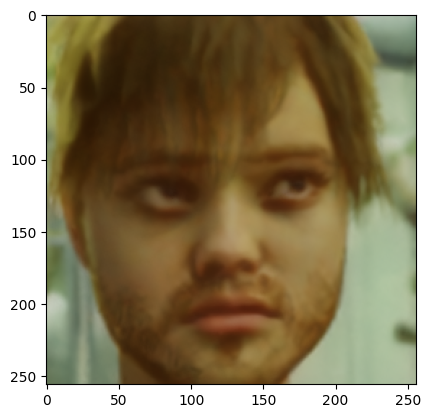

69it [00:01, 36.74it/s]


Step 69 ; Error 0.026969200000166893


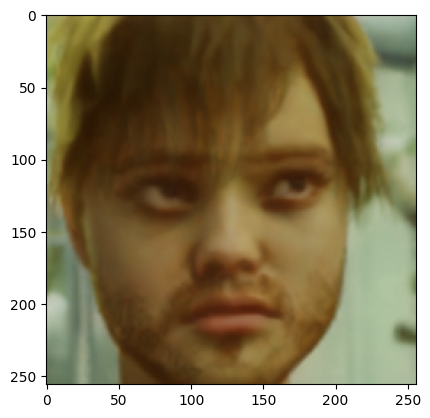

79it [00:02, 36.67it/s]


Step 79 ; Error 0.028191344812512398


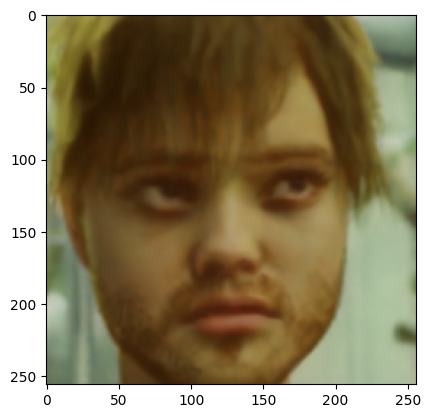

89it [00:02, 36.25it/s]


Step 89 ; Error 0.0295881275087595


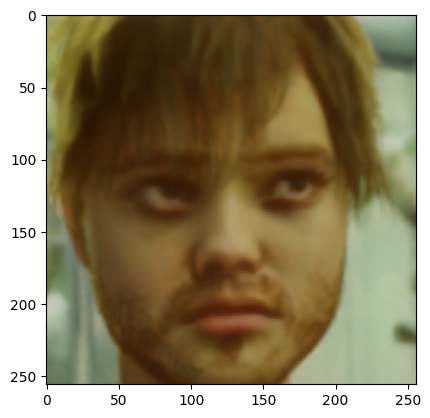

99it [00:02, 36.29it/s]


Step 99 ; Error 0.031186044216156006


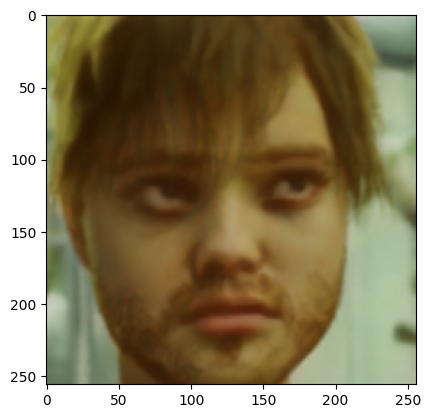

109it [00:03, 36.15it/s]


Step 109 ; Error 0.03299373760819435


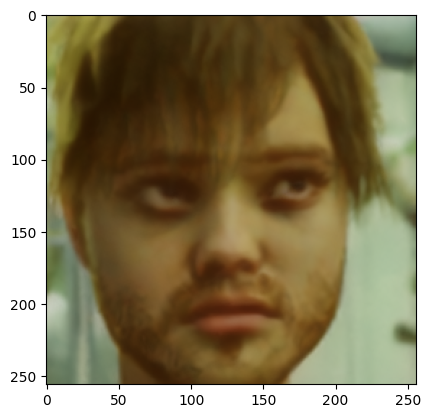

119it [00:03, 36.93it/s]


Step 119 ; Error 0.03501259163022041


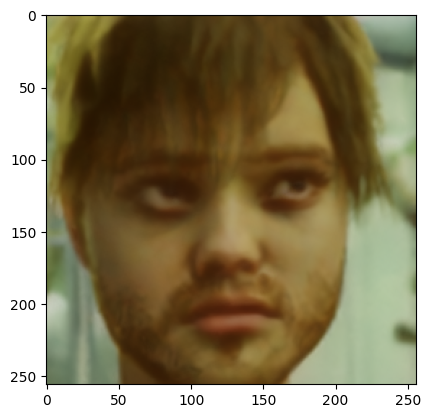

129it [00:03, 36.74it/s]


Step 129 ; Error 0.03722323849797249


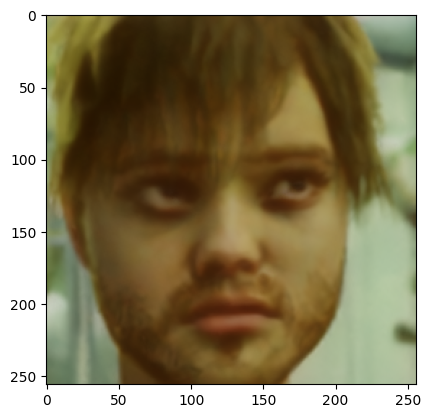

139it [00:03, 36.60it/s]


Step 139 ; Error 0.03958926722407341


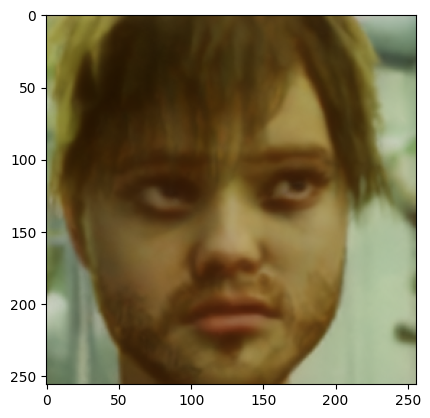

149it [00:10, 14.50it/s]


Step 149 ; Error 0.04204723611474037


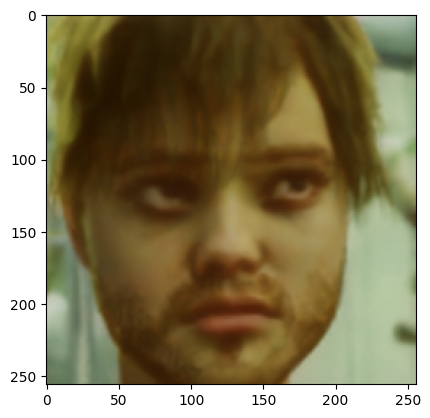

159it [00:12, 12.94it/s]


Step 159 ; Error 0.044512178748846054


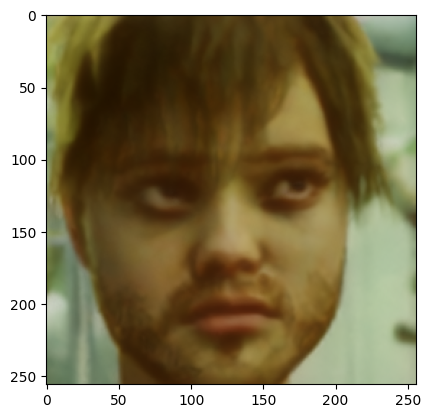

169it [00:13, 12.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 169 ; Error 0.04690514877438545


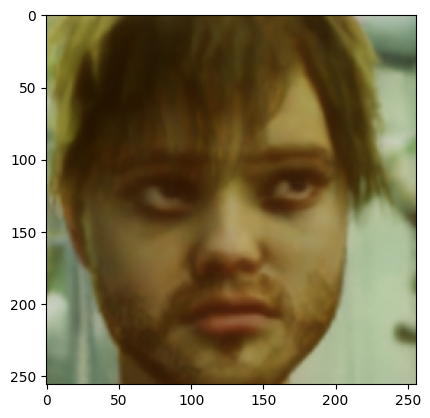

179it [00:13, 12.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 179 ; Error 0.049174752086400986


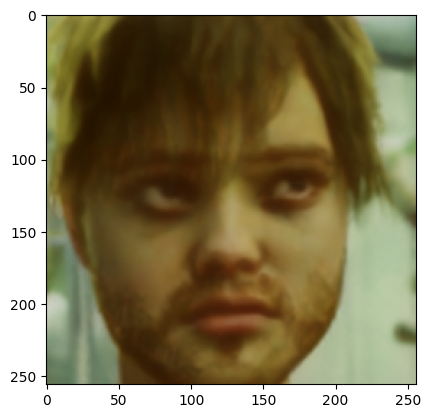

189it [00:14, 12.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 189 ; Error 0.05125784873962402


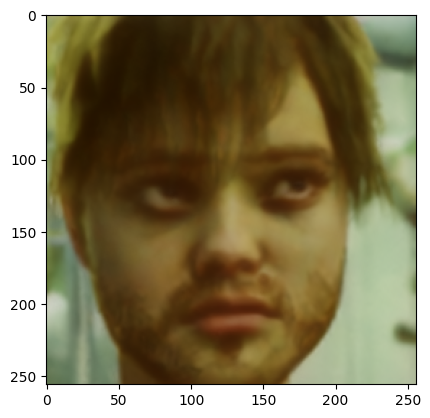

199it [00:14, 13.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 199 ; Error 0.053117990493774414


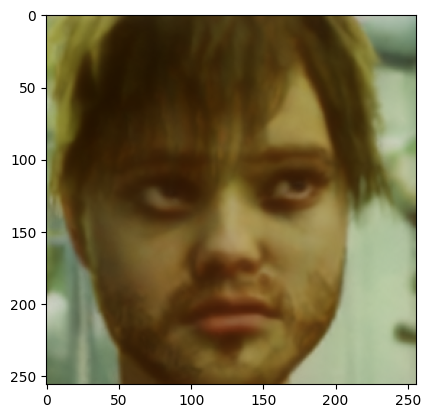

200it [00:15, 12.97it/s]


Step 200 ; Error 0.05096469447016716


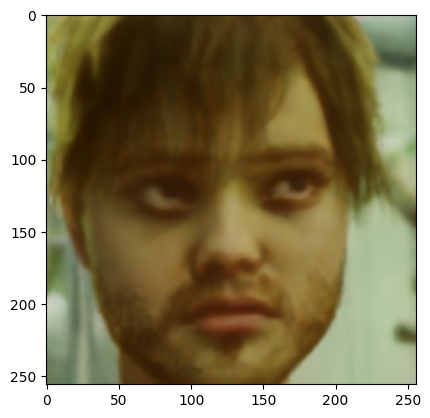

In [55]:
list_images = [latent]
for image in list_images:
    device="cuda:3"
    inputs = image.to(device)
    encoded_inputs = EncodingInput(inputs.squeeze(), spaced_diffusion, unet)
    seed = encoded_inputs[-1].cuda(2)
    number_of_sample = 1
    difference = {}
    starting_t = 120
    ### 1000 -> 999 , 500 --> 499
    for starting_t in range(9,200,10):
        seed = encoded_inputs[starting_t-1].cuda(3)
        ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(unet,[number_of_sample,3,64,64], 
                              clip_denoised=True,clip_value=1.4, noise=seed.repeat(number_of_sample,1,1,1),eta = 0., langevin=False,add_noise=True, starting_t=starting_t)
        ddpm_of_post_resampled_tensor = []
        with torch.no_grad():
            for dic in tqdm(ddpm_imagenet_sample):
                ddpm_of_post_resampled_tensor.append(dic['sample'].cpu())
        difference[starting_t] = ((inputs.data.cpu()-ddpm_of_post_resampled_tensor[-1])**2).mean()
        print(f"Step {starting_t} ; Error {difference[starting_t]}")
        with torch.no_grad():
            plt.imshow(vqvae.decode(vqvae.quantize(ddpm_of_post_resampled_tensor[-1].cuda(3))[0])[0].squeeze().detach().permute(1,2,0).cpu()/2+0.5)
            plt.show()
    ## full reverse
    starting_t = 200
    seed = encoded_inputs[starting_t-1].cuda(3)
    ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(unet,[number_of_sample,3,64,64], 
                          clip_denoised=True,clip_value=1.4,noise=seed.repeat(number_of_sample,1,1,1),eta = 0., 
                            langevin=False,add_noise=True, starting_t=starting_t)
    ddpm_of_post_resampled_tensor = []
    with torch.no_grad():
        for dic in tqdm(ddpm_imagenet_sample):
            ddpm_of_post_resampled_tensor.append(dic['sample'].cpu())
    difference[starting_t] = ((inputs.data.cpu()-ddpm_of_post_resampled_tensor[-1])**2).mean()
    print(f"Step {starting_t} ; Error {difference[starting_t]}")
    with torch.no_grad():
        plt.imshow(vqvae.decode(vqvae.quantize(ddpm_of_post_resampled_tensor[-1].cuda(3))[0])[0].squeeze().detach().permute(1,2,0).cpu()/2+0.5)
        plt.show()

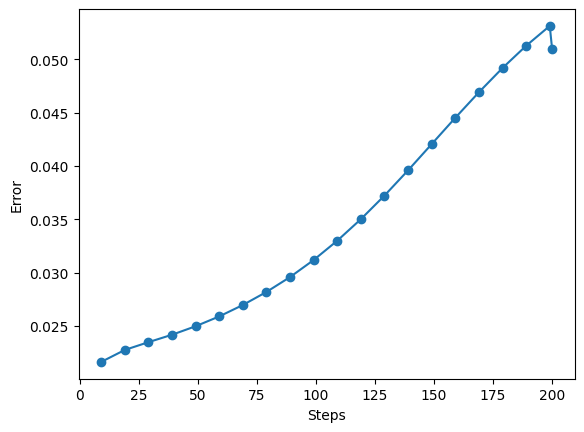

In [57]:
def plot_dictionary_scatter(dictionary):
    keys = dictionary.keys()
    values = dictionary.values()
    plt.plot(keys, values, '-o')
    # plt.scatter(keys, values)
    plt.xlabel("Steps")
    plt.ylabel("Error")
    # plt.title(‘Dictionary Scatter Plot’)
    plt.show()
plot_dictionary_scatter(difference)

In [ ]:
name = f"/home/bastienvandelft/digiface1m_subject_0/0/0.png"
transform_resize_down = Resize(256)
to_tensor = ToTensor()
# transform_resize_up = Resize(512)
inputs_normalized= PIL.Image.open(name)
inputs_normalized = inputs_normalized.convert('RGB')
inputs_normalized_64 = to_tensor(transform_resize_down(inputs_normalized\
                                                   ))
inputs = (inputs_normalized_64 - 0.5) *2
device="cuda:3"
inputs = inputs.to(device)
encoded_inputs = EncodingInput(inputs, spaced_diffusion, unet)
number_of_sample = 1
k = 250
langevin_step = 50
epsilon = 3e-6
starting_t = 200 - 1
### 1000 -> 999 , 500 --> 499
seed = encoded_inputs[starting_t-1].cuda(2)
results = ODEdit(seed, spaced_diffusion, unet,number_of_sample, k, langevin_step, epsilon, starting_t=starting_t)
for image in (results.data.cpu()/2+0.5):
    plt.imshow(image.permute(1,2,0).numpy())
    plt.show()

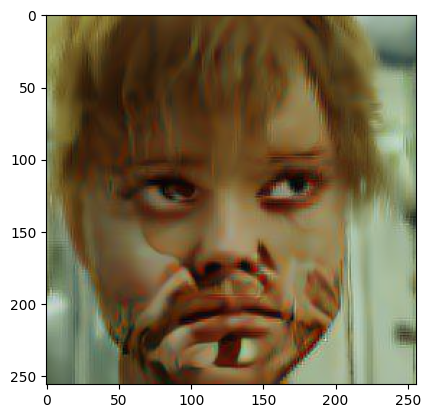

In [54]:
for image in (results.data.cpu()/2+0.5):
    plt.imshow(image.permute(1,2,0).numpy())
    plt.show()

In [58]:
images =  (results.data.cpu()/2+0.5)
((inputs_normalized_64 - images[0])**2).mean()

tensor(0.0003)

In [27]:
# # latent_post = vqvae.quantize(ddpm_of_resampled_tensor[-1].cuda(1))
# latent_post = ddpm_of_resampled_tensor[-1]
# q_post = vqvae.quantize(latent_post.cuda(1))
# output = vqvae.decode(q_post[0].cuda(1))[0].squeeze(0).detach().cpu().permute(1,2,0) / 2 + 0.5
# # output = vqvae.decode(latent_post.cuda(1))[0].squeeze(0).detach().cpu().permute(1,2,0) / 2 + 0.5 
# plt.imshow(output)
large = ddpm_of_resampled_tensor[-1]

In [48]:
def ODEdit(encoded_inputs,diffusion,  net_model, number_of_sample=2, K=500, langevin_step=10, epsilon=5e-8):
    ddpm_imagenet_sample = diffusion.ddim_sample_loop_progressive(net_model,[number_of_sample,2,64,64], 
                          clip_denoised=True,clip_value=2.5,noise=encoded_inputs.repeat(number_of_sample,1,1,1),eta = 0., 
                                                                  langevin=True,add_noise=True,temperature=1, epsilon=epsilon, K=K, 
                                                                         langevin_step = langevin_step, clip_distance=0.)
    ddpm_of_post_resampled_tensor = []
    with torch.no_grad():
        for dic in tqdm(ddpm_imagenet_sample):
            ddpm_of_post_resampled_tensor.append(dic['sample'].cpu())
    return ddpm_of_post_resampled_tensor

In [ ]:
reco = ODEdit(ddpm_of_reencoded_tensor[-1].cuda(3), spaced_diffusion, unet)

43it [03:05,  4.69s/it]

In [ ]:
plt.figure(figsize=(10,5))
sample = reco[-1]
# latent_post = ddpm_of_resampled_tensor[-1]
# q_corrected = vqvae.quantize(sample.cuda(1))
# output = vqvae.decode(q_corrected[0].cuda(1))[0].detach().cpu() / 2 + 0.5 
# plt.imshow(output)
# sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = sample /2 + 0.5
sample = make_grid(sample.cpu()).permute(1,2,0)
# sample = make_grid(output.cpu()).permute(1,2,0)
plt.imshow(sample)

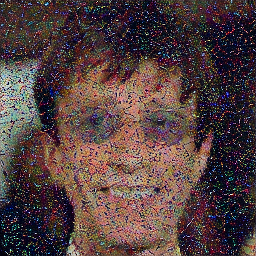

In [36]:
PIL.Image.open("./ddpm/samples/reconstruction_direct_0.png")

In [68]:
save_image(sample.permute(2,0,1), "./ddpm/samples/ldm_test_3.png")
save_image(input_tensor/2+0.5, "./ddpm/samples/input_3.png")
save_image(img_tensor/2+0.5, "./ddpm/samples/target_3.png")
save_image(reconstruction[0].squeeze().detach().cpu()/2+0.5, "./ddpm/samples/reconstruction_direct_3.png")

In [4]:
from torchvision.transforms import Resize, ToTensor
corruption = "masking_vline_random_color"
corruption_severity=3
name = f"/home/bastienvandelft/Projects/DiffBIR/inputs/demo/face/aligned/{corruption}_{corruption_severity}_face_512.png"

transform_resize_down = Resize(64)
to_tensor = ToTensor()
# transform_resize_up = Resize(512)
inputs_normalized= PIL.Image.open(name)
inputs_normalized_64 = to_tensor(transform_resize_down(inputs_normalized\
                                                   ))
inputs = (inputs_normalized_64 - 0.5) *2
# save_image(inputs_normalized_512,name)

In [87]:
transform_resize_up = Resize(512)
vq_decoding = transform_resize_up(sample.cpu().detach())
original = transform_resize_up(inputs_normalized_64.cpu())
name = f"/home/bastienvandelft/Projects/ddpm/samples/VQVAE_reconstruction.png"
save_image(vq_decoding,name)
original_name = f"/home/bastienvandelft/Projects/ddpm/samples/original_masking.png"
save_image(original,original_name)        

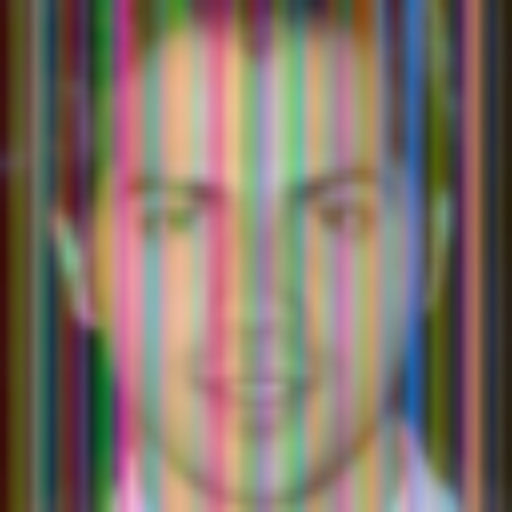

In [90]:
name = f"/home/bastienvandelft/Projects/ddpm/samples/ODE_reconstruction.png"
PIL.Image.open(name)


In [7]:
imagenet_retrain_64 = torch.load('/mnt/scitas/bastien/logs/IMAGENET/Imagenet_RESCALED_MSE_[]_OAITrue_2023-08-18_18-55/ckpt_225000.pt')
# celeba_blur = torch.load('/mnt/scitas/bastien/logs/Celeba/CELEBA_gaussian_blur_x64_2023-08-12_21-16/ckpt_120000.pt')
# celeba = torch.load('/mnt/scitas/bastien/logs/Celeba/CELEBA_None_x64_2023-08-08_01-41/ckpt_170000.pt')
# celeba_snow = torch.load('/mnt/scitas/bastien/logs/Celeba/CELEBA_snow_x64_2023-08-17_16-44/ckpt_150000.pt')
# celeba_glass = torch.load('/mnt/scitas/bastien/logs/Celeba/CELEBA_glass_blur_x64_2023-08-17_16-44/ckpt_10000.pt')
# imagenet_snow_checkpoint = torch.load("/mnt/scitas/bastien/logs/IMAGENET/Imagenet_256ch_True_['snow']_x256_2023-07-19_13-05/ckpt_36000.pt")
# imagenet_retrain_openai_checkpoint = torch.load('/mnt/scitas/bastien/logs/IMAGENET/Imagenet_256ch_True_[]_x256_2023-07-19_12-59/ckpt_12000.pt')
imagenet_config = DictConfig(imagenet_retrain_64['config'])
# celeba_blur_config = DictConfig(celeba_blur['config'])
# celeba_snow_config = DictConfig(celeba_snow['config'])
# celeba_glass_config = DictConfig(celeba_glass['config'])

In [8]:
celeba = False
if celeba:
    class Crop(object):
        def __init__(self, x1, x2, y1, y2):
            self.x1 = x1
            self.x2 = x2
            self.y1 = y1
            self.y2 = y2
    
        def __call__(self, img):
            return F.crop(img, self.x1, self.y1, self.x2 - self.x1, self.y2 - self.y1)
    
        def __repr__(self):
            return self.__class__.__name__ + "(x1={}, x2={}, y1={}, y2={})".format(
                self.x1, self.x2, self.y1, self.y2
            )
    cx = 89
    cy = 121
    x1 = cy - 64
    x2 = cy + 64
    y1 = cx - 64
    y2 = cx + 64
    
    dataset_name = celeba_config.trainer.dataset
    datapath = celeba_config.trainer.datapath
    corruption_severity = celeba_config.trainer.corruption_severity
    corruption = celeba_config.trainer.corruption
    random_flip = celeba_config.trainer.random_flip
    lower_image_size = celeba_config.trainer.lower_image_size
    image_size = celeba_config.trainer.img_size
    original_img_size = OmegaConf.to_object(celeba_config.trainer.original_img_size)
    
    celeba_transform = transforms.Compose(
                        [Crop(x1, x2, y1, y2),
                            transforms.Resize(celeba_config.trainer.img_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ]
                    )
# train_dataset = CelebA(root="/mnt/scitas/bastien/",
#                 split="train",
#                 corruption=celeba_config.trainer.corruption,
#                 corruption_severity=celeba_config.trainer.corruption_severity
#                 ,transform = celeba_transform)
# celeba_glass_config['trainer']["split"] = "test"
# glass_dataset = CelebA(root="/mnt/scitas/bastien/",
#                 split="test",
#                 corruption=celeba_glass_config.trainer.corruption,
#                 corruption_severity=celeba_glass_config.trainer.corruption_severity,transform = celeba_transform)
# snow_dataset = CelebA(root="/mnt/scitas/bastien/",
#                 split="test",
#                 corruption=celeba_snow_config.trainer.corruption,
#                 corruption_severity=celeba_snow_config.trainer.corruption_severity,transform = celeba_transform)
# blur_dataset = CelebA(root="/mnt/scitas/bastien/",
#                 split="test",
#                 corruption=celeba_blur_config.trainer.corruption,
#                 corruption_severity=3,transform = celeba_transform)
# bw_dataset = CelebA(root="/mnt/scitas/bastien/",
#                 split="test",
#                 corruption="black_and_white",
#                 corruption_severity=3,transform = celeba_transform)
# masking_random_color_dataset = CelebA(root="/mnt/scitas/bastien/",
#                 split="test",
#                 corruption="masking_vline_random_color",
#                 corruption_severity=3,transform = celeba_transform)

In [9]:
from gc import collect
collect()

236

In [16]:
### IMAGENET
%load_ext autoreload
%autoreload 2
import os
import torch
import numbers
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from ddpm.datasets.imagenet import Imagenet_Dataset
# 
from omegaconf import DictConfig, OmegaConf, open_dict
import yaml
from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
from ddpm.model import UNet
from ddpm.ddib_model import UNetModel
from ddpm.ddib_diffusion import GaussianDiffusion, SpacedDiffusion, _extract_into_tensor, space_timesteps, LossType, ModelMeanType, ModelVarType, get_named_beta_schedule
import importlib
from ddpm.utils.utils import proc_metrics, compute_psnr, compute_ssim

torch.cuda.empty_cache()
import gc
gc.collect()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


508

In [11]:
def extract(a, t, x_shape):
    """Extract coefficients from a based on t and reshape to make it
    broadcastable with x_shape."""
    bs, = t.shape
    assert x_shape[0] == bs
    out = torch.gather(torch.tensor(a, dtype=torch.float, device=t.device), 0, t.long())
    assert out.shape == (bs,)
    out = out.reshape((bs,) + (1,) * (len(x_shape) - 1))
    return out




def image_editing_denoising_step_flexible_mask(x, t, *,
                                               model,
                                               logvar,
                                               betas):
    """
    Sample from p(x_{t-1} | x_t)
    """
    alphas = 1.0 - betas
    alphas_cumprod = alphas.cumprod(dim=0)

    model_output = model(x, t.int())
    weighted_score = betas / torch.sqrt(1 - alphas_cumprod)
    mean = extract(1 / torch.sqrt(alphas), t, x.shape) * (x - extract(weighted_score, t, x.shape) * model_output)

    logvar = extract(logvar, t, x.shape)
    noise = torch.randn_like(x)
    mask = 1 - (t == 0).float()
    mask = mask.reshape((x.shape[0],) + (1,) * (len(x.shape) - 1))
    sample = mean + mask * torch.exp(0.5 * logvar) * noise
    sample = sample.float()
    return sample

def p_sample_loop_bis(
        self,
        model,
        shape,
        noise=None,
        number_step=200,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
):
    """
    Generate samples from the model.
    :param model: the model module.
    :param shape: the shape of the samples, (N, C, H, W).
    :param noise: if specified, the noise from the encoder to sample.
                  Should be of the same shape as `shape`.
    :param clip_denoised: if True, clip x_start predictions to [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample.
    :param cond_fn: if not None, this is a gradient function that acts
                    similarly to the model.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :param device: if specified, the device to create the samples on.
                   If not specified, use a model parameter's device.
    :param progress: if True, show a tqdm progress bar.
    :return: a non-differentiable batch of samples.
    """
    final = None
    for sample in p_sample_loop_progressive_bis(self,
            model,
            shape,
            noise=noise,
            number_step=number_step,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
    ):
        final = sample
    return final["sample"]


def p_sample_loop_progressive_bis(
        diffusion,
        model,
        shape,
        noise=None,
        number_step=200,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
):
    """
    Generate samples from the model and yield intermediate samples from
    each timestep of diffusion.
    Arguments are the same as p_sample_loop().
    Returns a generator over dicts, where each dict is the return value of
    p_sample().
    """
    if device is None:
        device = next(model.parameters()).device
    assert isinstance(shape, (tuple, list))
    if noise is not None:
        img = noise
    else:
        img = torch.randn(*shape, device=device)
    indices = list(range(number_step))[::-1]

    if progress:
        # Lazy import so that we don't depend on tqdm.
        from tqdm.auto import tqdm

        indices = tqdm(indices)

    for i in indices:
        t = torch.tensor([i] * shape[0], device=device)
        with torch.no_grad():
            out = diffusion.p_sample(
                model,
                img,
                t,
                clip_denoised=clip_denoised,
                denoised_fn=denoised_fn,
                cond_fn=cond_fn,
                model_kwargs=model_kwargs,
            )
            yield out
            img = out["sample"]

def SDEditing(diffusion, model, image, sample_step, total_noise_levels, n=4):
    print("Start sampling")
    with torch.no_grad():
        model.eval()
        # [mask, img] = torch.load("colab_demo/{}.pth".format(name))
        img = image
        mask = torch.zeros_like(img)
        mask = mask.to(device)
        img = img.to(device)
        img = img.unsqueeze(dim=0)
        img = img.repeat(n, 1, 1, 1)
        x0 = img
        # x0 = (x0 - 0.5) * 2.
        plt.imshow(make_grid(x0.data.cpu()/2 + 0.5).permute(1,2,0).numpy())
        plt.show()
        for it in range(sample_step):
            # e = torch.randn_like(x0)
            # a = (1 - betas).cumprod(dim=0).to(device)
            # x = x0 * a[total_noise_levels - 1].sqrt() + e * (1.0 - a[total_noise_levels - 1]).sqrt()
            t = torch.tensor([total_noise_levels-1] * x0.shape[0], device=device)
            x = diffusion.q_sample(x0,t)
            plt.imshow(make_grid(x.data.cpu()/2 + 0.5).permute(1,2,0).numpy())
            plt.show()

            

            # with tqdm(total=total_noise_levels, desc="Iteration {}".format(it)) as progress_bar:
            x = p_sample_loop_bis(diffusion,
                                model,
                                x.shape,
                                noise=x,
                                number_step=total_noise_levels,
                                clip_denoised=True,
                                denoised_fn=None,
                                cond_fn=None,
                                model_kwargs=None,
                                device=None,
                                progress=True,)
                # samples = diffusion.p_sample_loop_progressive(diffusion,model,x0.shape,noise=None,clip_denoised = True)
                # ddpm_of_resampled_tensor = []
                # ddpm_of_resampled_attentions = []
                # with torch.no_grad():
                #     for j, dic in enumerate(samples):
                #         ddpm_of_resampled_tensor.append(dic['sample'].cpu())
                #         if j % 100 == 0:
                #             print(f"{total_noise_levels - j} steps")
                #             plt.imshow(make_grid(dic['sample'].cpu()/2 + 0.5).permute(1,2,0).numpy())
                #             plt.show()
                        # ddpm_of_resampled_attentions.append(dic['attention_maps'])
                # x = ddpm_of_resampled_tensor[-1]
            #     for i in reversed(range(total_noise_levels)):
            #         # t = (torch.ones(n) * i).to(device)
            #         t = torch.tensor([i] * x.shape[0], device=device)
            #         # x_ = image_editing_denoising_step_flexible_mask(x, t=t, model=model,
            #                                                         # logvar=logvar,betas=betas)
            #         dic = diffusion.p_sample(model, x, t, clip_denoised=True,)                                             
            #         x = x0 * a[i].sqrt() + e * (1.0 - a[i]).sqrt()
            #         x[:, (mask != 1.)] = x_[:, (mask != 1.)]
            #         # added intermediate step vis
            #         if (i - 99) % 100 == 0:
            #             imshow(x, title="Iteration {}, t={}".format(it, i))
            #         progress_bar.update(1)

            # x0[:, (mask != 1.)] = x[:, (mask != 1.)]
            # plt.imshow(make_grid(x.data.cpu()).permute(1,2,0).numpy())
        plt.imshow(make_grid(x.cpu()/2 + 0.5).permute(1,2,0).numpy())
        plt.show()
        return x.data.cpu()

In [13]:
attention_resolutions = [32,16,8]
attention_ds = []
for res in attention_resolutions:
    attention_ds.append(64 // int(res))
class_cond = False 
diffusion_steps = imagenet_config.trainer.num_timesteps 
# image_size = 256 
image_size = 64 
learn_sigma = True #True 
noise_schedule = 'linear' #imagenet_cfg.trainer.beta_schedule 
num_channels = 128 #256 
num_head_channels = -1 
num_heads = 4
num_res_blocks = imagenet_config.trainer.num_res_blocks 
resblock_updown = imagenet_config.trainer.resblock_updown  
use_fp16 = False
use_scale_shift_norm = False
input_channels = 3
model_var_type = ModelVarType.LEARNED_RANGE
model_mean_type = ModelMeanType.EPSILON
loss_type = LossType.RESCALED_MSE
# if imagenet_cfg.trainer.input_channel == 1:
#     out_channels = 1
# else:
out_channels = (3 if not learn_sigma else 6)
net_model = UNetModel(image_size,
                in_channels = input_channels,
                model_channels = num_channels, #128
                out_channels = out_channels,
                num_res_blocks = num_res_blocks, #2
                attention_resolutions = tuple(attention_ds),
                dropout=0.,
                channel_mult=(1, 2, 3, 4), #(1, 1, 2, 2, 4, 4),
                conv_resample=True,
                dims=2,
                num_classes=None,
                use_checkpoint=False,
                use_fp16=False,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                num_heads_upsample=-1,
                use_scale_shift_norm=use_scale_shift_norm,
                resblock_updown=resblock_updown,
                use_new_attention_order=False,
                timesteps=diffusion_steps)


print("Unets instantiated.")

# ckpt_imagenet = torch.load(imagenet_cfg.trainer.imagenet_256_ckpt)
# ckpt_imagenet = torch.load('/mnt/scitas/bastien/imagenet_diffusion/256x256_diffusion_uncond.pt')
# net_model.load_state_dict(imagenet_retrain_checkpoint['ema_model'])
# imagenet_model.load_state_dict(ckpt_imagenet)
net_model.load_state_dict(imagenet_retrain_64['ema_model'])
net_model.eval()
net_model = net_model.cuda(2)
# imagenet_model = imagenet_model.cuda(3)
print("Models Loaded.")

Unets instantiated.
Models Loaded.


In [14]:
ddim_steps = 100

noise_schedule = 'linear'#imagenet_cfg.trainer.beta_schedule 
diffusion_steps = imagenet_config.trainer.num_timesteps
betas = get_named_beta_schedule(noise_schedule, diffusion_steps)
                                
diffusion = GaussianDiffusion(betas = betas,
                    model_mean_type = model_mean_type,
                    model_var_type = model_var_type,
                    loss_type = loss_type,
                    rescale_timesteps = False)

# betas = torch.from_numpy(diffusion.betas)
# logvar = np.log(np.maximum(diffusion.posterior_variance, 1e-20))
# logvar = diffusion.posterior_log_variance_clipped

timesteps_respacing = f"ddim{ddim_steps}"

spaced_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(diffusion_steps, timesteps_respacing),
                        betas=betas,
                        model_mean_type=model_mean_type,
                        model_var_type=model_var_type,
                        loss_type=loss_type,
                        rescale_timesteps=False,
                        )

quick_spaced_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(diffusion_steps, 'ddim100'),
                        betas=betas,
                        model_mean_type=model_mean_type,
                        model_var_type=model_var_type,
                        loss_type=loss_type,
                        rescale_timesteps=False,
                        )
print("Diffusions instantiated")

Diffusions instantiated


In [20]:
imagenet_cfg = {}
imagenet_cfg = imagenet_config
imagenet_cfg['trainer']['datapath'] = '/mnt/scitas/datasets/imagenet'
# imagenet_cfg['trainer']["open_ai_normalization"] = True
imagenet_cfg['trainer']["split"] = "val"



imagenet_cfg = DictConfig(imagenet_cfg)

imagenet_train_transform =  transforms.Compose(
                    [   transforms.ToTensor(),
                        transforms.Resize([128]),
                        transforms.CenterCrop(128),    
                    ]
                )

train_dataset_imagenet = Imagenet_Dataset(imagenet_config,transform = imagenet_train_transform)

No corruption


In [ ]:
vqvae.encode()

In [ ]:
# from diffusers import LDMPipeline

# # load model and scheduler
# pipe = LDMPipeline.from_pretrained("CompVis/ldm-celebahq-256")

In [ ]:
# # import requests
# from PIL import Image
# # from io import BytesIO
# from diffusers import StableDiffusionUpscalePipeline
# # import torch

# # load model and scheduler
# model_id = "stabilityai/stable-diffusion-x4-upscaler"
# pipeline = StableDiffusionUpscalePipeline.from_pretrained(
#     model_id, revision="fp16", torch_dtype=torch.float16
# )


In [ ]:
# pipeline = pipeline.to("cuda")
# low_res_img = Image.open("/home/bastienvandelft/Projects/DiffBIR/inputs/ODE/Image_ODE/frost_3_K_3_L_2_1_64to512_ODE_0.png").convert("RGB")
# low_res_img = low_res_img.resize((64, 64))
# prompt = "a face"

# upscaled_image = pipeline(prompt=prompt, image=low_res_img).images[0]
# upscaled_image.save("upsampled_cat.png")

In [ ]:
# %load_ext autoreload
# %autoreload 2
# from ddpm.datasets.corruptions import masking_simple, masking_random_color, masking_gaussian, masking_line
# corruption="frost"
# corruption_severity=1
# test_dataset = CelebA(root="/mnt/scitas/bastien/",
#                 split="test",
#                 corruption=corruption,
#                 corruption_severity=corruption_severity,transform = celeba_transform)
# # openai_0 = test_dataset[6][0]
# # sample_openai = ((openai_0 + 1) * 127.5).clamp(0, 255).to(torch.uint8)
# # sample_openai = ((openai_0/2)+0.5)
# # plt.imshow(sample_openai.permute(1,2,0).numpy())

100it [00:31,  3.22it/s]


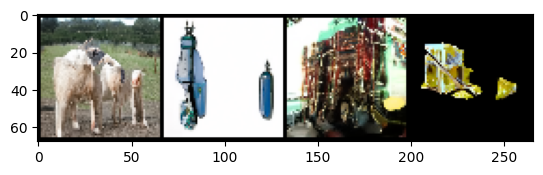

In [92]:
### TEST SAMPLING
seed_noise = torch.randn([4,3,64,64]).cuda(2)
ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(net_model,[4,3,64,64], 
                                                                     clip_denoised=True,noise=seed_noise)
ddpm_of_sampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_sampled_tensor.append(dic['sample'].cpu())
sample = ddpm_of_sampled_tensor[-1]
sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = make_grid(sample.cpu()).permute(1,2,0)
plt.imshow(sample)

In [50]:
sample.min()

0.0

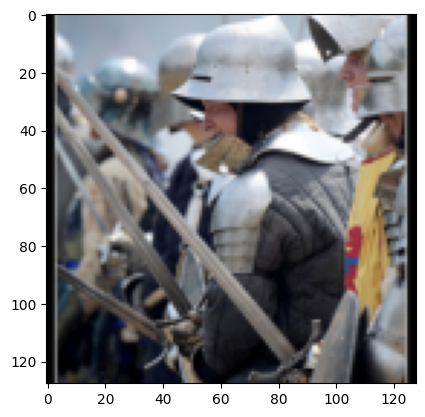

In [27]:
card_sample = 6
inputs = train_dataset_imagenet[card_sample][0]
targets = train_dataset_imagenet[card_sample][1]

from ddpm.datasets.corruptions import *
from torchvision.transforms import Resize, ToTensor, ToPILImage
# to_tensor = ToTensor()
# inputs = to_tensor(transform_resize_down(image))
to_image = ToPILImage()
# targets = to_tensor(transform_resize_target(image))
target_image = to_image(targets)
pil_input_image = to_image(((inputs + 1) * 127.5).clamp(0, 255).to(torch.uint8))
sample_targets = (((targets + 1) * 127.5).clamp(0.255).to(torch.uint8).permute(1,2,0).cpu().detach()) / 255
sample = masking_gaussian(pil_input_image,1)
sample = np.array(sample) / 255.
sample_tensor_normalized = torch.from_numpy(sample)
newsample = make_grid(sample_targets) #.permute(1,2,0)
plt.imshow(newsample)



In [46]:
latent = vqvae.encode(inputs.unsqueeze(0))[0]
q = vqvae.quantize(latent)[0]
decoded = vqvae.decode(q)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


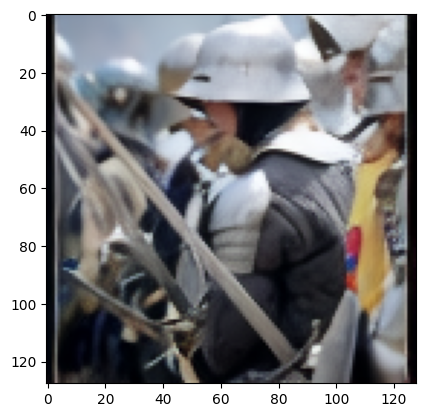

In [47]:
a= decoded[0][0].permute(1,2,0).cpu().detach() / 2 +0.5
plt.imshow(a)

In [69]:
### Test Encoding
unet = unet.cuda(3)
vqvae = vqvae.cuda(1)
spaced_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(diffusion_steps, timesteps_respacing),
                        betas=betas,
                        model_mean_type=model_mean_type,
                        model_var_type=ModelVarType.FIXED_LARGE,
                        loss_type=LossType.MSE,
                        rescale_timesteps=False,
                        )
reversing_inputs = inputs.unsqueeze(0).cuda(2) 
reversing_inputs = latent.cuda(3)
spaced_diffusion.not_hugginface = False
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(unet,reversing_inputs,
                                                                             clip_denoised=True, eta=0.)
ddpm_of_reencoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_reencoded_tensor.append(dic['sample'].cpu())
\


ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(unet,[1,3,128,128], 
                                                clip_denoised=True,noise=ddpm_of_reencoded_tensor[-1].cuda(3))
ddpm_of_resampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_resampled_tensor.append(dic['sample'].cpu())

100it [00:02, 43.88it/s]
100it [00:02, 42.39it/s]


In [72]:
ddpm_of_resampled_tensor[-1].shape

torch.Size([1, 3, 32, 32])

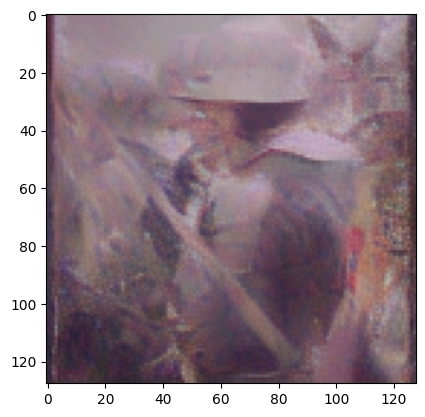

In [75]:
# latent_post = vqvae.quantize(ddpm_of_resampled_tensor[-1].cuda(1))
latent_post = ddpm_of_resampled_tensor[-1]
output = vqvae.decode(latent_post.cuda(1))[0].squeeze(0).detach().cpu().permute(1,2,0) / 2 + 0.5 
plt.imshow(output)

In [138]:
def ODEdit(encoded_inputs,diffusion,  net_model, number_of_sample=3, K=100, langevin_step=ddim_steps, epsilon=2e-6):
    ddpm_imagenet_sample = diffusion.ddim_sample_loop_progressive(net_model,[number_of_sample,3,64,64], 
                          clip_denoised=True,noise=encoded_inputs.repeat(number_of_sample,1,1,1),eta = 0., langevin=True,add_noise=True,temperature=1/3, epsilon=epsilon, K=K, 
                                                                         langevin_step = langevin_step, clip_distance=0.)
    ddpm_of_post_resampled_tensor = []
    with torch.no_grad():
        for dic in tqdm(ddpm_imagenet_sample):
            ddpm_of_post_resampled_tensor.append(dic['sample'].cpu())
    return ddpm_of_post_resampled_tensor

100it [00:06, 15.54it/s]
100it [00:06, 15.38it/s]


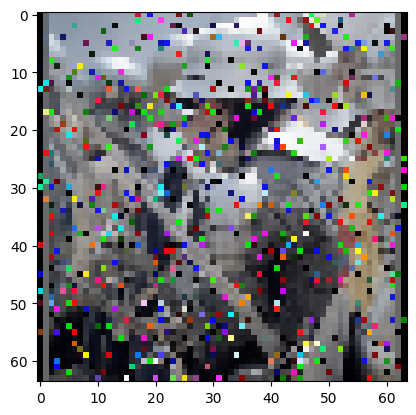

In [94]:
### Test Encoding
seed = (sample_tensor_normalized.permute(2,0,1).float() - 0.5)*2
reversing_inputs = seed.unsqueeze(0).cuda(2) 
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(net_model,reversing_inputs,
                                                                             clip_denoised=True, eta=0.)
ddpm_of_reencoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_reencoded_tensor.append(dic['sample'].cpu())
\


ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(net_model,[1,3,64,64], 
                                                clip_denoised=True,noise=ddpm_of_reencoded_tensor[-1].cuda(2))
ddpm_of_resampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_resampled_tensor.append(dic['sample'].cpu())

## Reconstruction
newsample = ddpm_of_resampled_tensor[-1]
newsample = ((newsample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
newsample = make_grid(newsample.cpu().detach()).permute(1,2,0)
plt.imshow(newsample)

In [145]:
ddpm_of_post_resampled_tensor = ODEdit(ddpm_of_reencoded_tensor[-1].cuda(2), spaced_diffusion, net_model,number_of_sample=1, K=150, langevin_step=20, epsilon=3e-6)


100it [00:47,  2.10it/s]


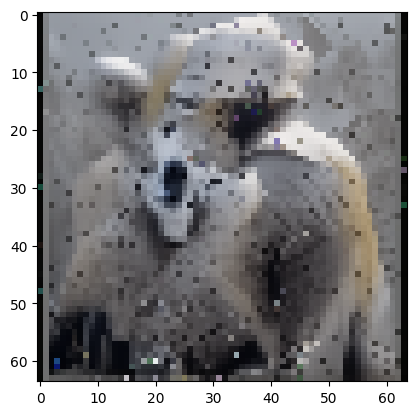

In [146]:
newsample = ddpm_of_post_resampled_tensor[-1]
newsample = ((newsample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
newsample = make_grid(newsample.cpu().detach()).permute(1,2,0)
plt.imshow(newsample)

In [15]:
from torchvision.transforms import Resize, ToTensor

name = f"/home/bastienvandelft/Projects/DiffBIR/inputs/demo/face/aligned/{corruption}_{corruption_severity}_face_512.png"

transform_resize_down = Resize(64)
to_tensor = ToTensor()
# transform_resize_up = Resize(512)
inputs_normalized= PIL.Image.open(name)
inputs_normalized_64 = to_tensor(transform_resize_down(inputs_normalized\
                                                   ))
inputs = (inputs_normalized_64 - 0.5) *2
# save_image(inputs_normalized_512,name)

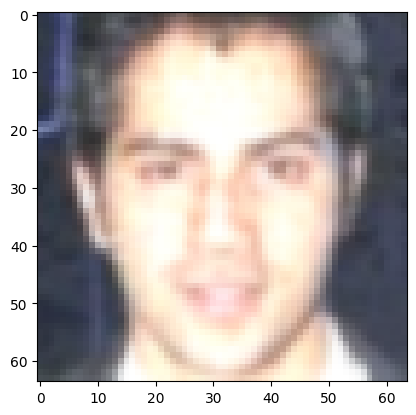

In [16]:
sample = inputs_normalized_64
sample = make_grid(sample.cpu().permute(1,2,0).detach()) #.permute(1,2,0)
plt.imshow(sample)

In [17]:
sde = False
corruptions_list = ["spatter", "gaussian_blur", "glass_blur", "motion_blur", "frost", "snow", "contrast", "masking_vline_random_color", 
                      "elastic_transform", "masking_gaussian"]
severity_list = [1,3,5]


transform_resize_down = Resize(64)
transform_resize_up = Resize(512)
if sde :
    for corruption in corruptions_list:
        for severity in severity_list:
            for step in [100, 200, 300]:
                try:
                    name = f"/home/bastienvandelft/Projects/DiffBIR/inputs/demo/face/aligned/{corruption}_{severity}_face_512.png"
                    to_tensor = ToTensor()
                    inputs_normalized= PIL.Image.open(name)
                    inputs_normalized_64 = to_tensor(transform_resize_down(inputs_normalized))
                    inputs = (inputs_normalized_64 - 0.5) *2
                    if sde:
                        device="cuda:2"
                        test = inputs
                        results = SDEditing(diffusion, net_model, test, 1, step, n=2)
                    for i in range(len(results)):
                        to_save = results[i]/2+0.5
                        name = f"/home/bastienvandelft/Projects/ddpm/samples/SDE/{corruption}_{severity}_step_{step}_64to64_SDEdit_{i}.png"
                        save_image(to_save,name)
                        to_save = transform_resize_up(to_save)
                        name = f"/home/bastienvandelft/Projects/ddpm/samples/SDE/{corruption}_{severity}_step_{step}_64to512_SDEdit_{i}.png"
                        save_image(to_save,name)          
                except Exception as e:
                    print(e)




50it [00:05,  9.34it/s]
50it [00:04, 11.74it/s]
50it [00:27,  1.80it/s]


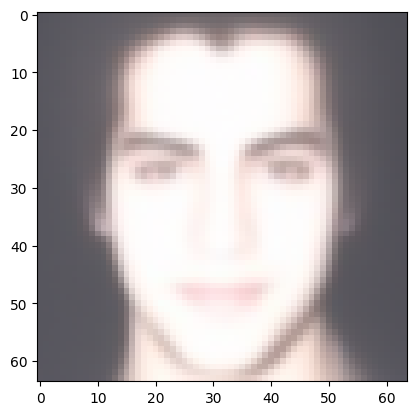

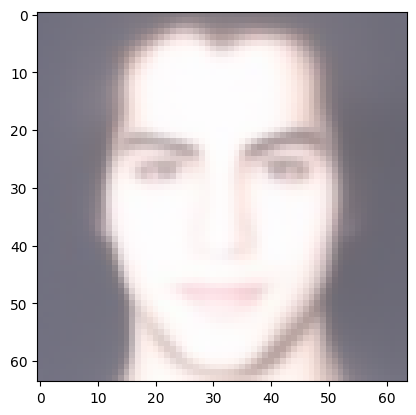

50it [00:03, 12.74it/s]
50it [00:03, 13.51it/s]
50it [00:27,  1.85it/s]


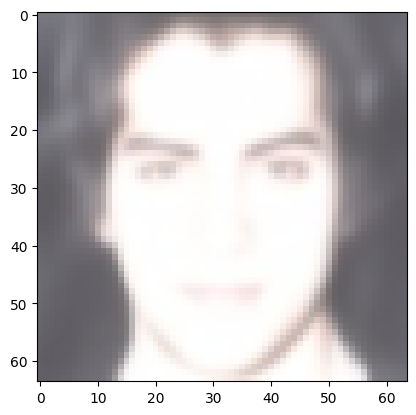

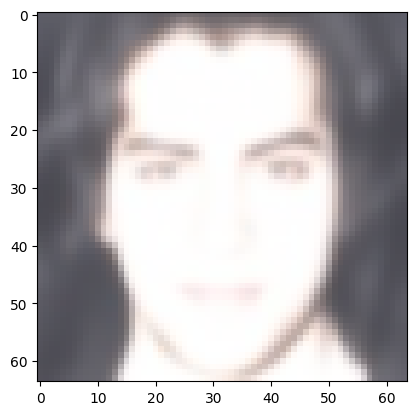

50it [00:03, 13.05it/s]
50it [00:03, 13.20it/s]
50it [00:27,  1.82it/s]


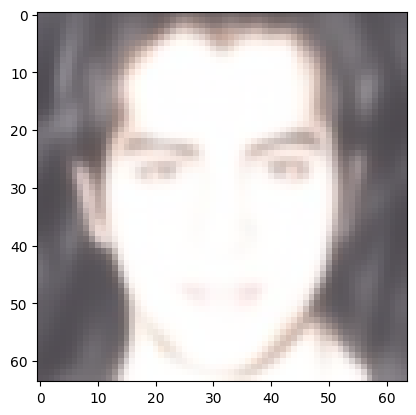

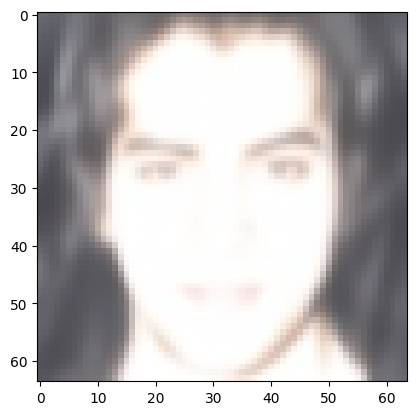

50it [00:04, 10.63it/s]
50it [00:04, 10.56it/s]
50it [00:27,  1.81it/s]


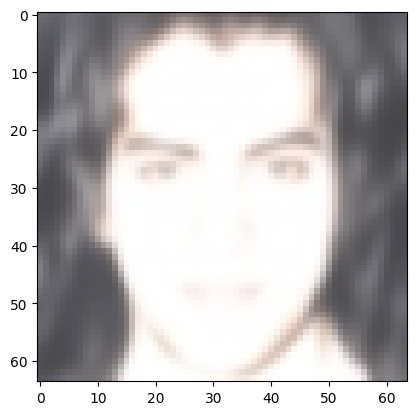

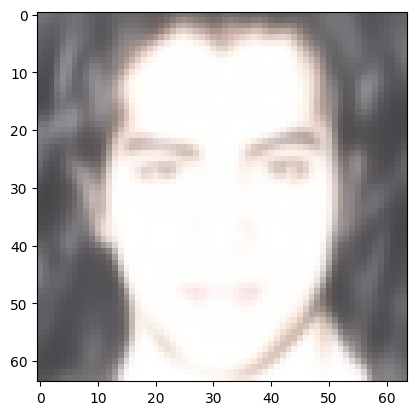

50it [00:04, 11.51it/s]
50it [00:04, 12.28it/s]
50it [00:27,  1.82it/s]


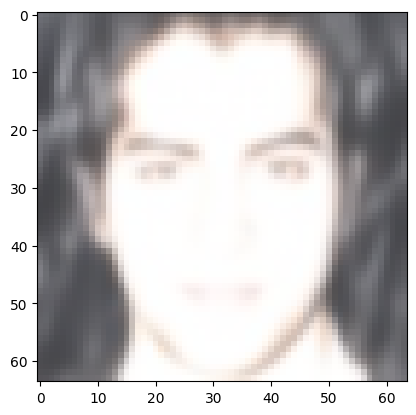

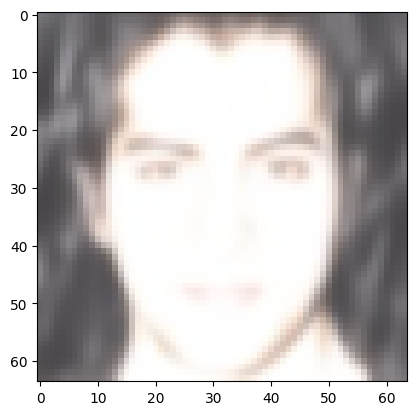

50it [00:04, 11.78it/s]
50it [00:03, 13.60it/s]
50it [00:13,  3.65it/s]


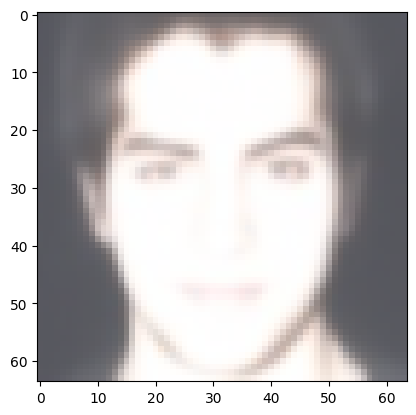

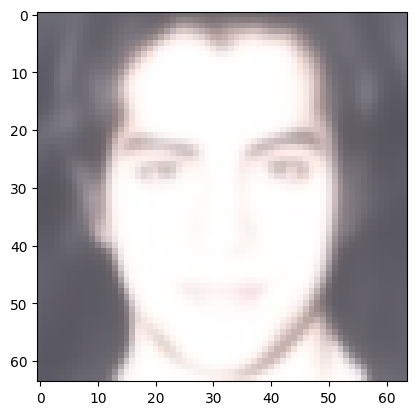

50it [00:04, 12.43it/s]
50it [00:04, 12.05it/s]
50it [00:13,  3.80it/s]


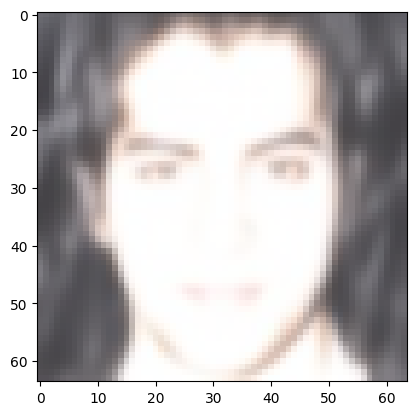

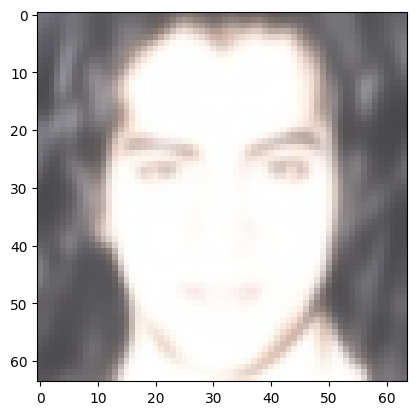

50it [00:03, 12.66it/s]
50it [00:03, 12.76it/s]
50it [00:13,  3.80it/s]


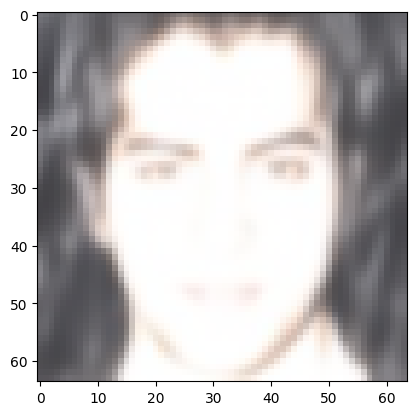

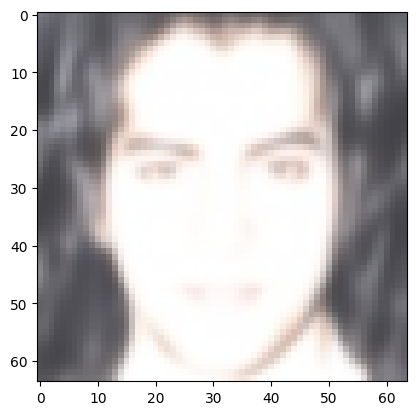

50it [00:03, 12.93it/s]
50it [00:04, 12.40it/s]
50it [00:13,  3.70it/s]


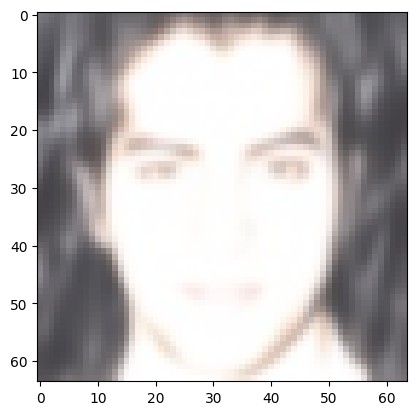

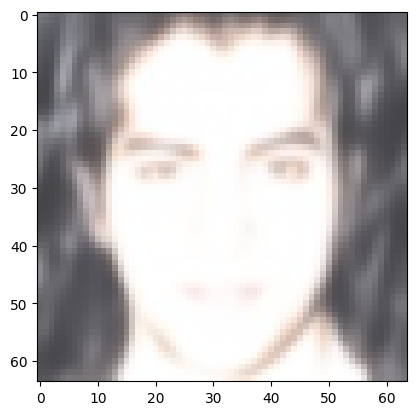

50it [00:03, 12.70it/s]
50it [00:04, 12.32it/s]
50it [00:13,  3.69it/s]


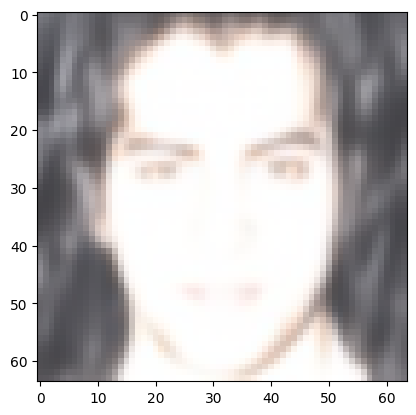

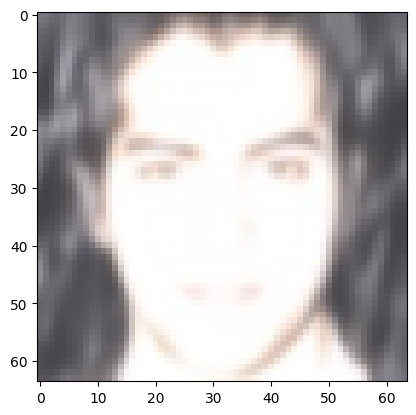

50it [00:03, 12.66it/s]
50it [00:03, 13.91it/s]
50it [00:13,  3.76it/s]


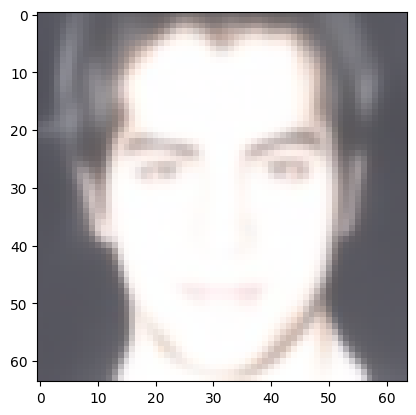

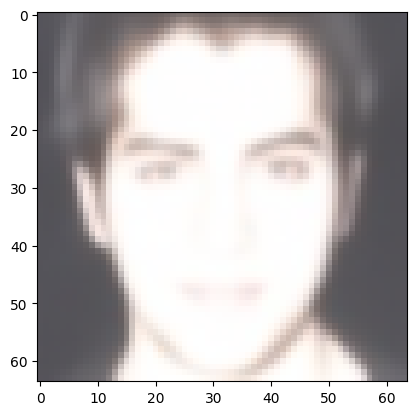

50it [00:03, 13.76it/s]
50it [00:03, 13.85it/s]
50it [00:13,  3.69it/s]


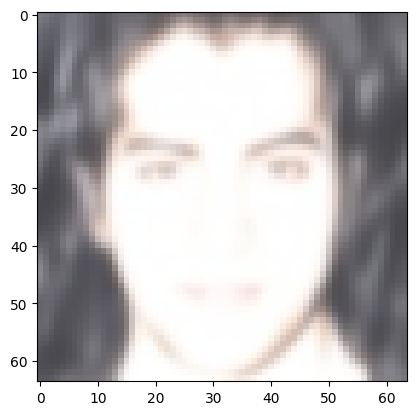

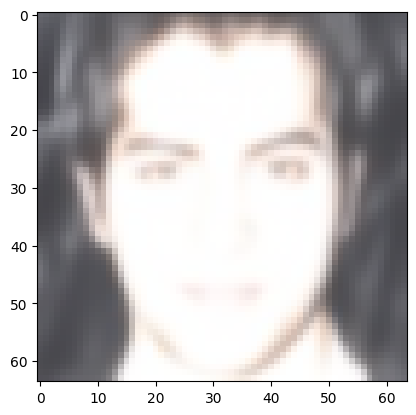

50it [00:03, 12.84it/s]
50it [00:03, 12.68it/s]
50it [00:13,  3.73it/s]


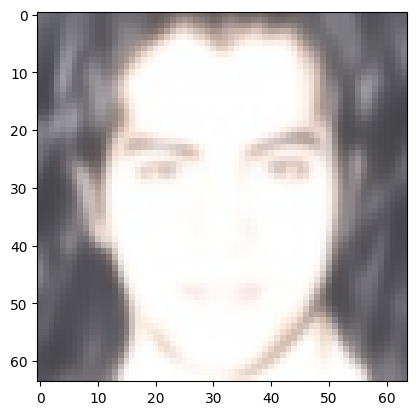

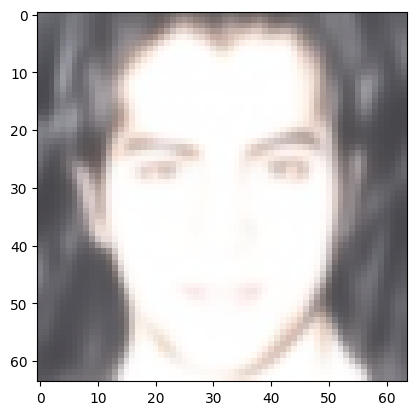

50it [00:03, 12.81it/s]
50it [00:03, 13.33it/s]
50it [00:13,  3.73it/s]


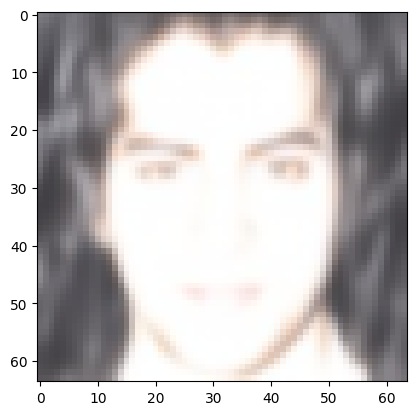

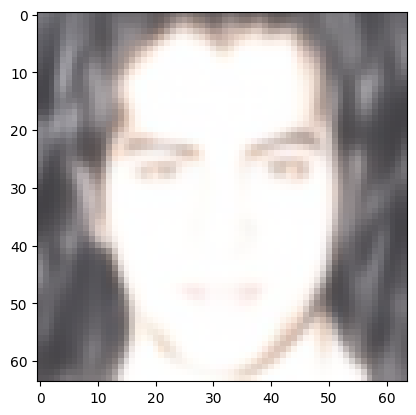

50it [00:03, 12.91it/s]
50it [00:03, 13.86it/s]
50it [00:12,  3.86it/s]


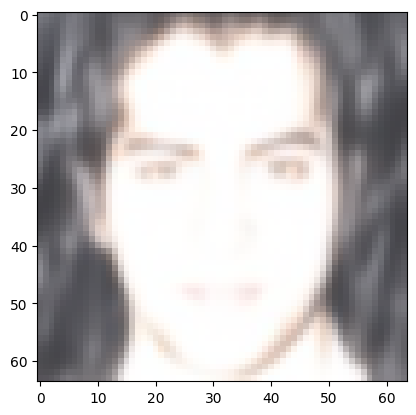

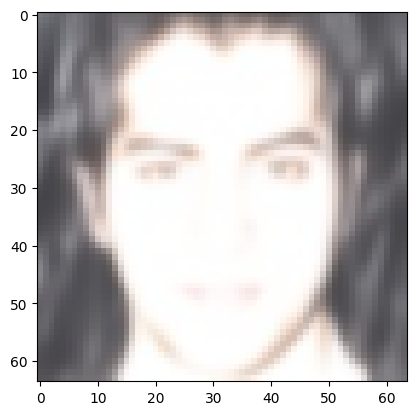

50it [00:03, 13.63it/s]
50it [00:03, 12.89it/s]
50it [00:11,  4.21it/s]


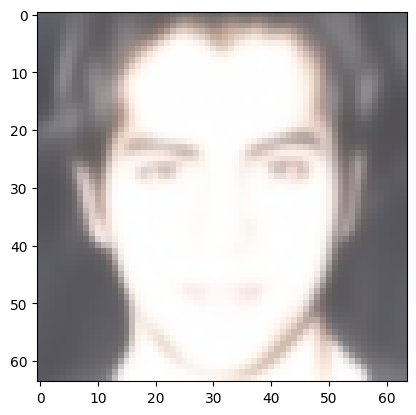

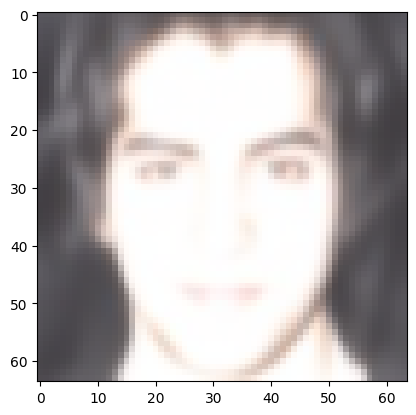

50it [00:03, 13.95it/s]
50it [00:03, 13.73it/s]
50it [00:11,  4.32it/s]


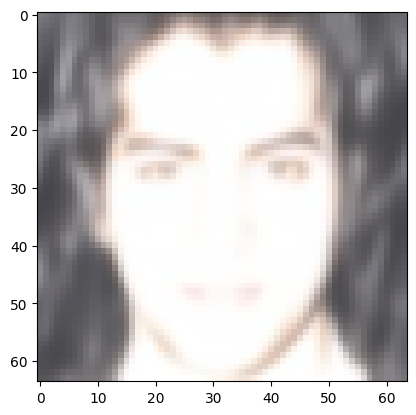

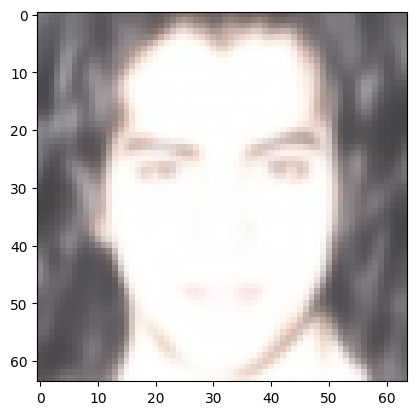

50it [00:03, 13.73it/s]
50it [00:03, 12.87it/s]
50it [00:12,  4.11it/s]


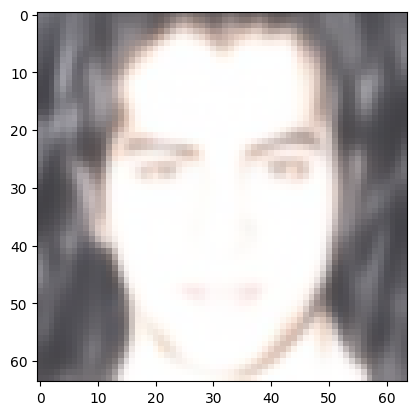

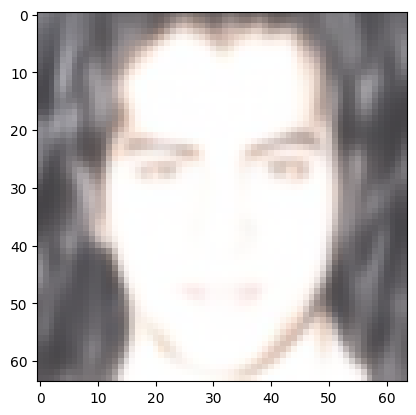

50it [00:03, 12.85it/s]
50it [00:03, 13.00it/s]
50it [00:12,  4.14it/s]


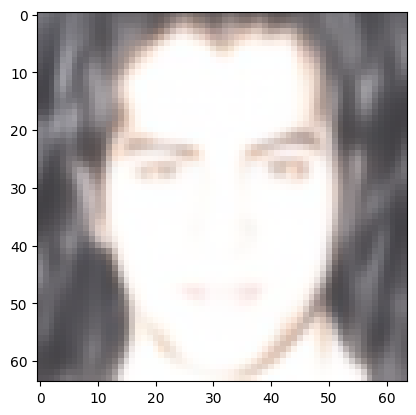

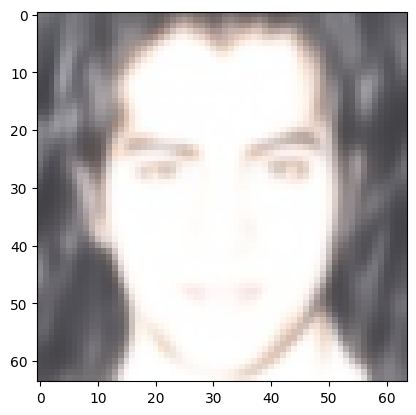

50it [00:03, 12.92it/s]
50it [00:03, 13.79it/s]
50it [00:11,  4.29it/s]


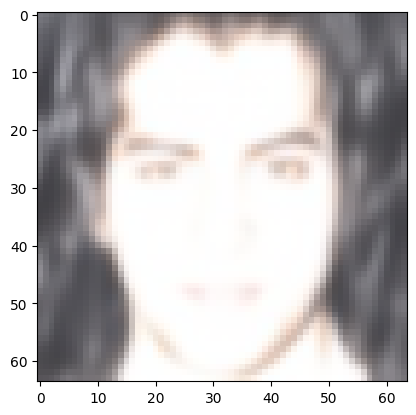

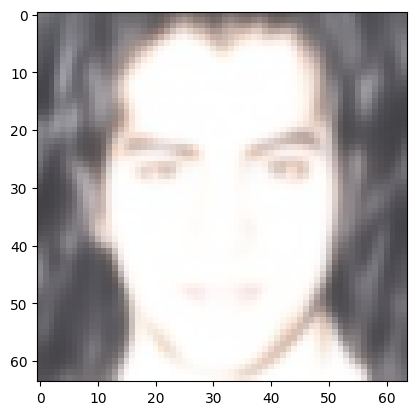

50it [00:03, 12.72it/s]
50it [00:03, 13.04it/s]
50it [00:32,  1.54it/s]


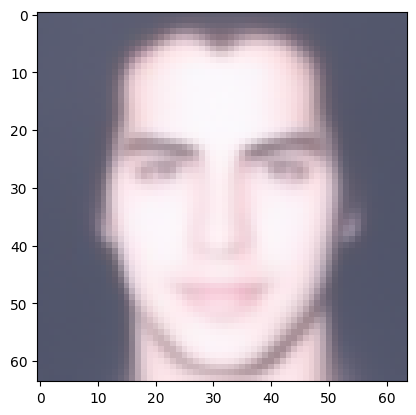

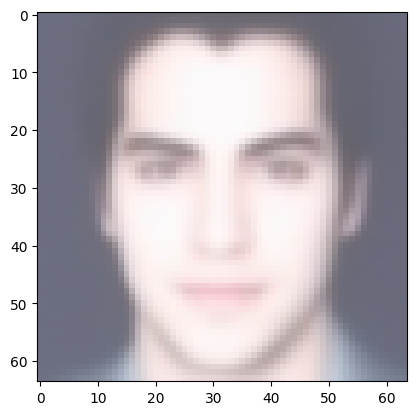

50it [00:04, 12.50it/s]
50it [00:03, 12.59it/s]
50it [00:32,  1.52it/s]


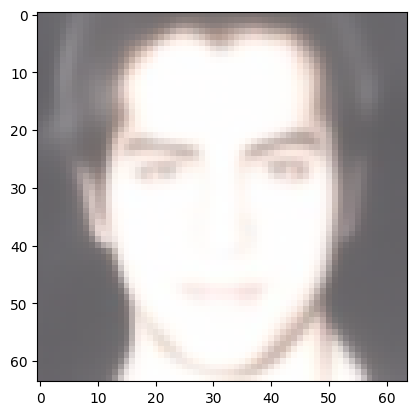

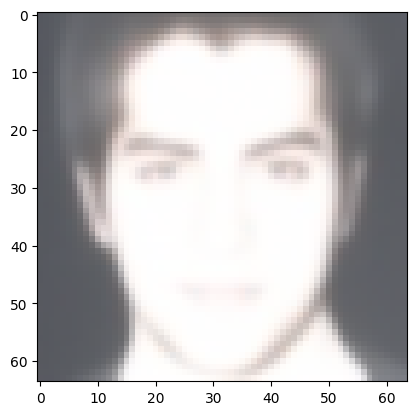

50it [00:03, 12.55it/s]
50it [00:04, 12.49it/s]
50it [00:31,  1.59it/s]


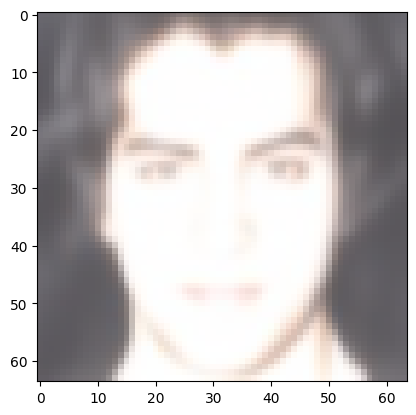

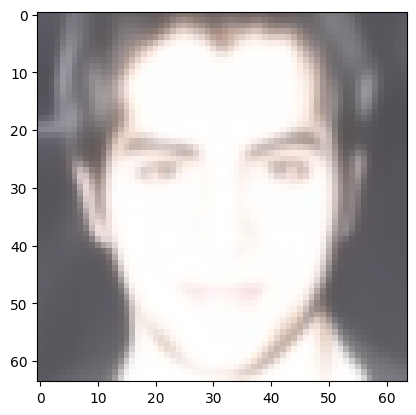

50it [00:03, 13.29it/s]
50it [00:03, 13.76it/s]
50it [00:32,  1.54it/s]


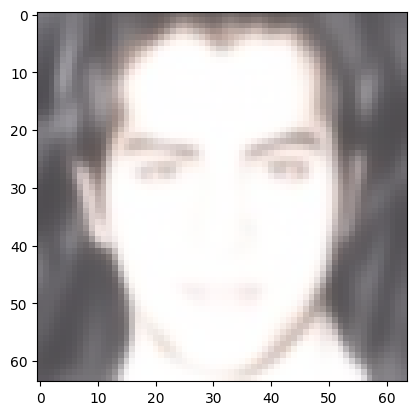

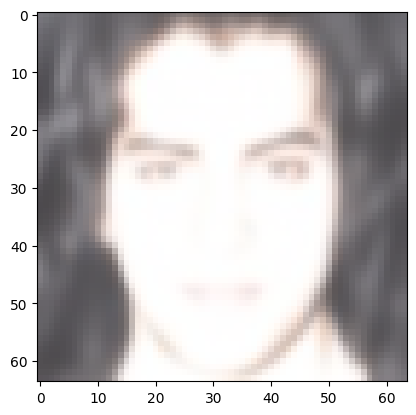

50it [00:03, 13.66it/s]
50it [00:03, 14.13it/s]
50it [00:32,  1.54it/s]


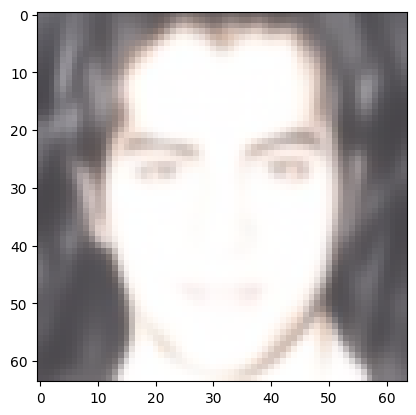

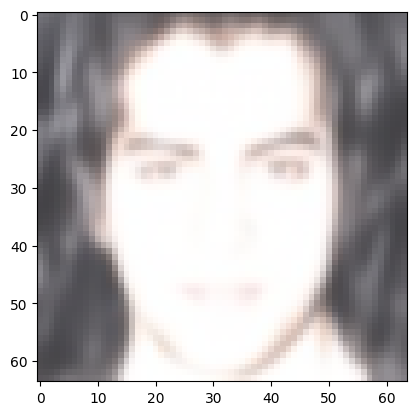

50it [00:04, 12.48it/s]
50it [00:04, 12.26it/s]
50it [00:33,  1.51it/s]


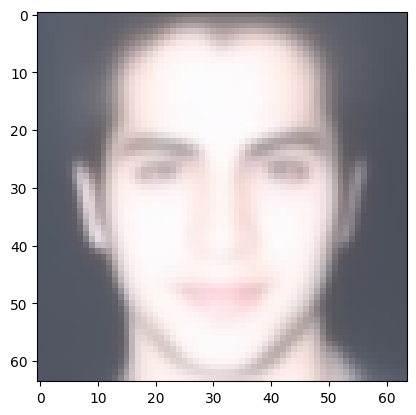

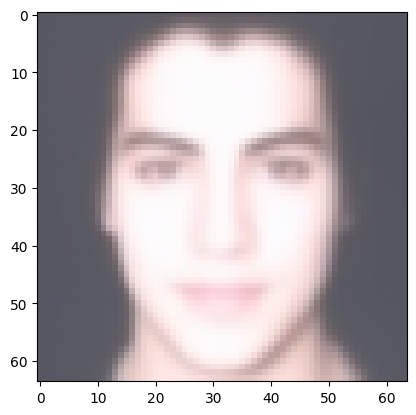

50it [00:03, 13.37it/s]
50it [00:03, 12.60it/s]
50it [00:32,  1.53it/s]


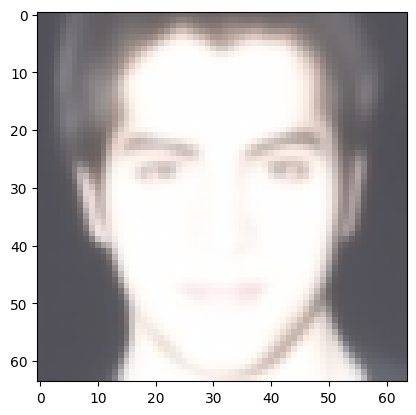

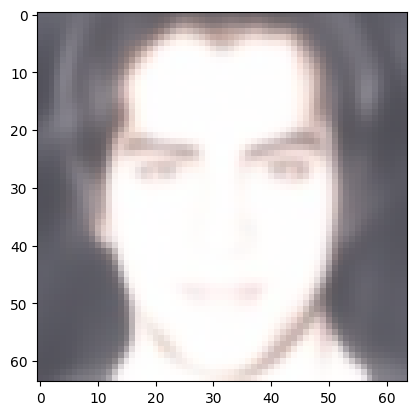

50it [00:03, 13.77it/s]
50it [00:03, 14.01it/s]
50it [00:33,  1.51it/s]


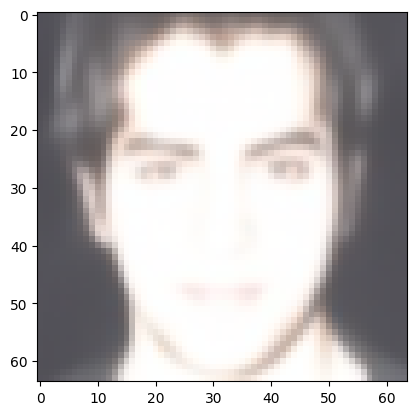

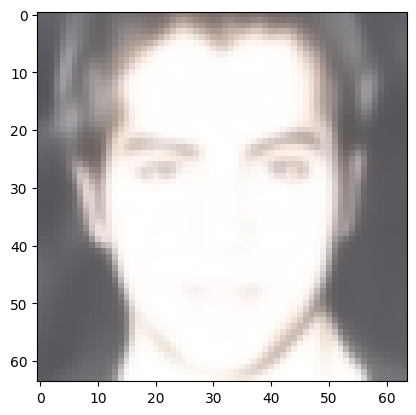

50it [00:04, 12.50it/s]
50it [00:03, 13.19it/s]
50it [00:32,  1.56it/s]


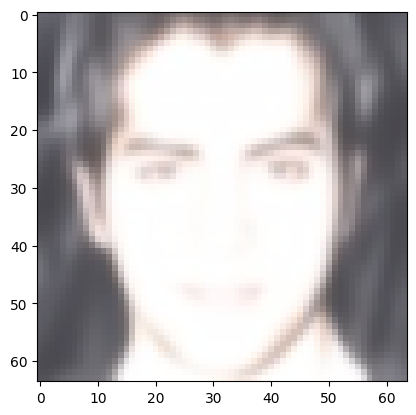

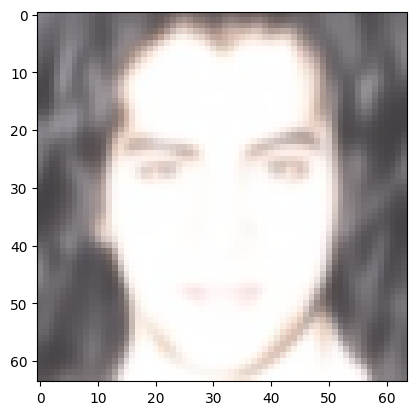

50it [00:03, 14.53it/s]
50it [00:03, 14.15it/s]
50it [00:30,  1.62it/s]


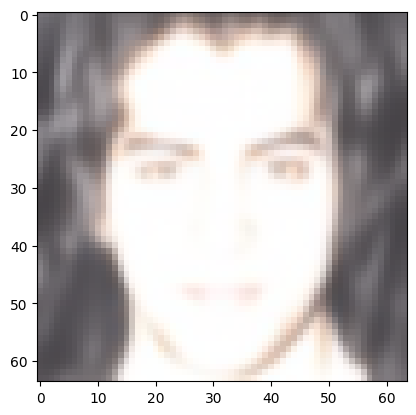

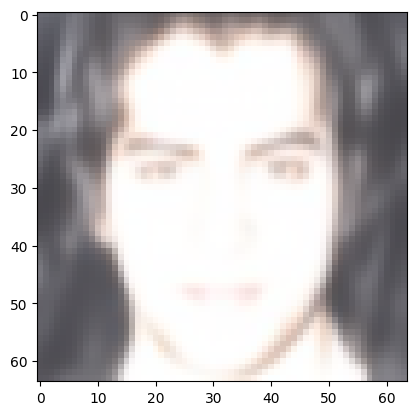

50it [00:03, 14.38it/s]
50it [00:03, 14.26it/s]
50it [00:22,  2.21it/s]


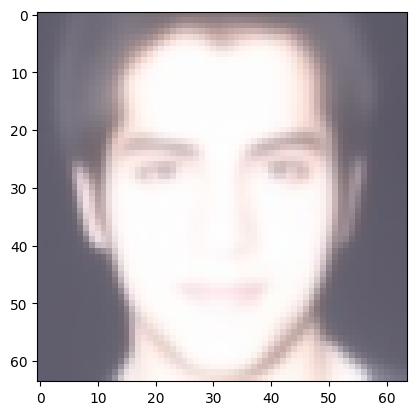

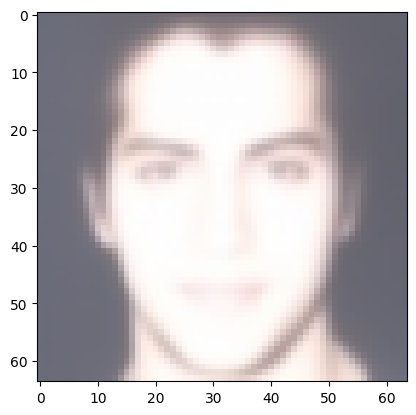

50it [00:03, 14.02it/s]
50it [00:03, 14.00it/s]
50it [00:22,  2.20it/s]


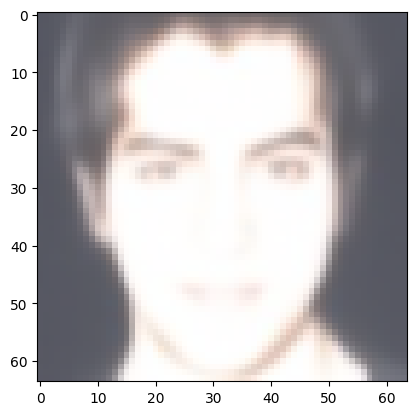

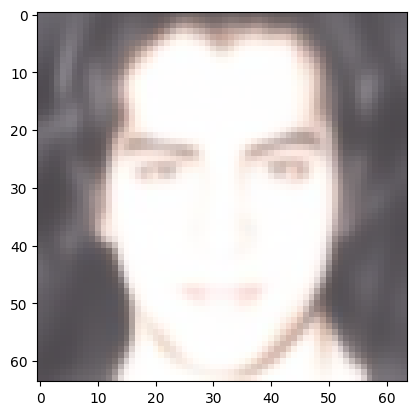

50it [00:03, 14.47it/s]
50it [00:03, 14.29it/s]
50it [00:21,  2.29it/s]


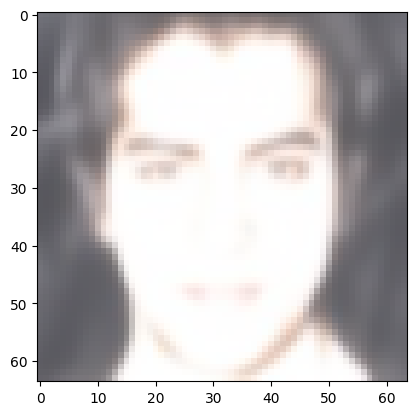

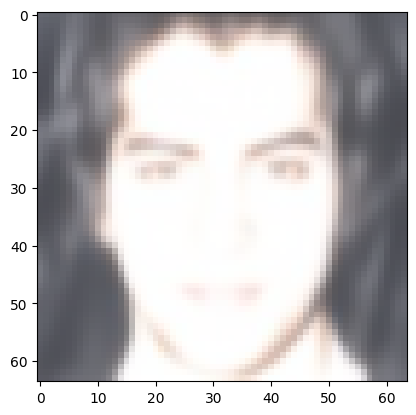

50it [00:03, 14.13it/s]
50it [00:03, 14.18it/s]
50it [00:22,  2.18it/s]


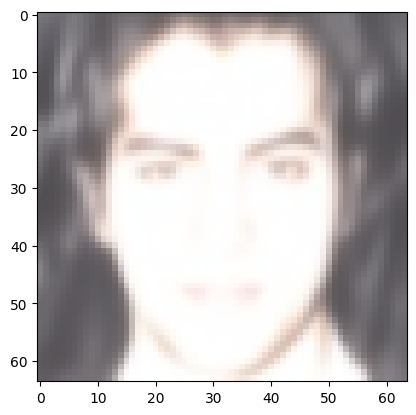

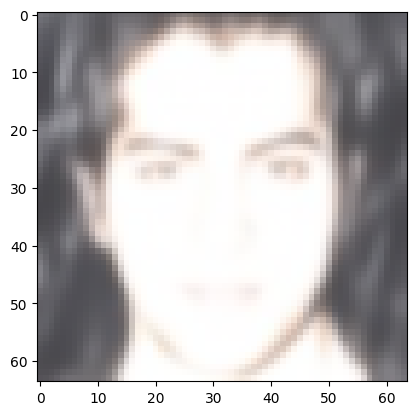

50it [00:03, 14.56it/s]
50it [00:03, 14.29it/s]
50it [00:23,  2.16it/s]


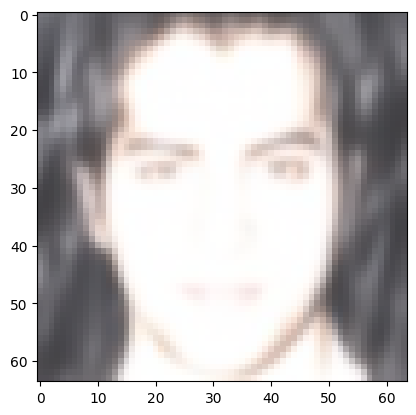

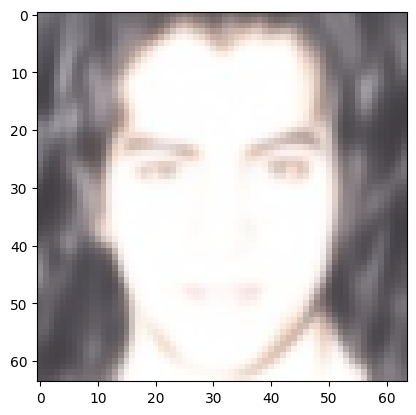

50it [00:03, 13.91it/s]
50it [00:03, 14.25it/s]
50it [00:59,  1.19s/it]


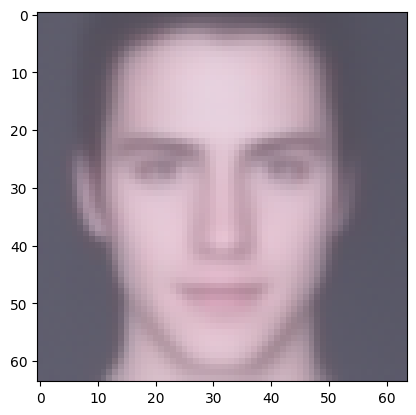

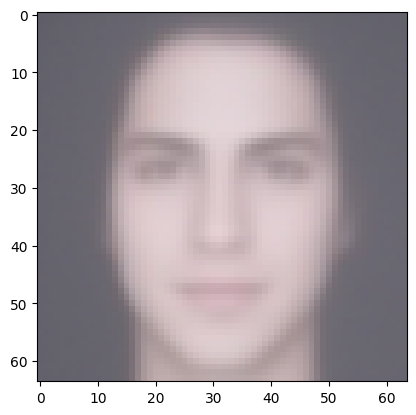

50it [00:03, 14.37it/s]
50it [00:03, 14.38it/s]
50it [01:03,  1.27s/it]


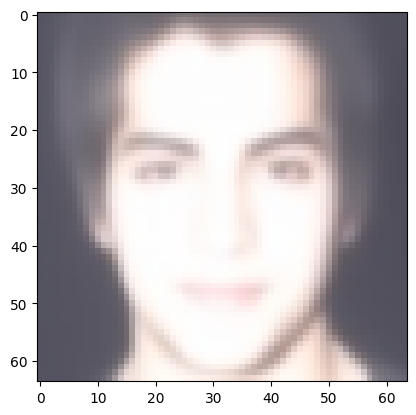

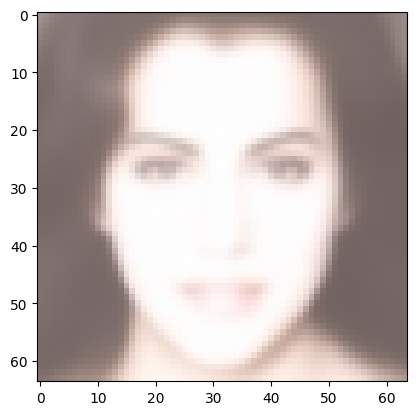

50it [00:03, 14.51it/s]
50it [00:03, 14.41it/s]
50it [00:58,  1.18s/it]


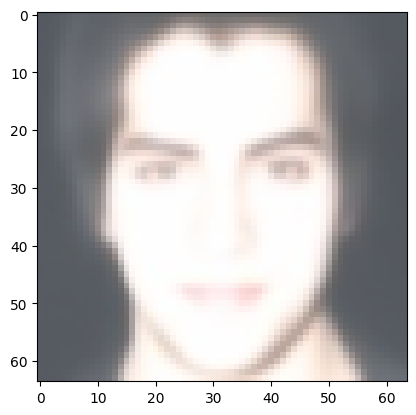

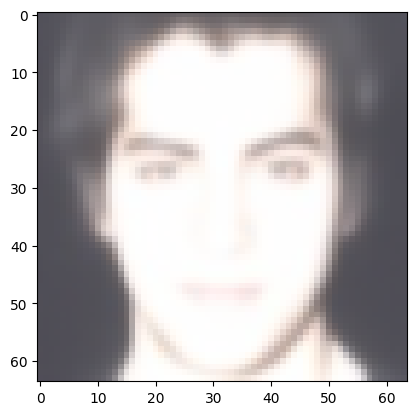

50it [00:03, 14.10it/s]
50it [00:03, 14.04it/s]
50it [01:00,  1.21s/it]


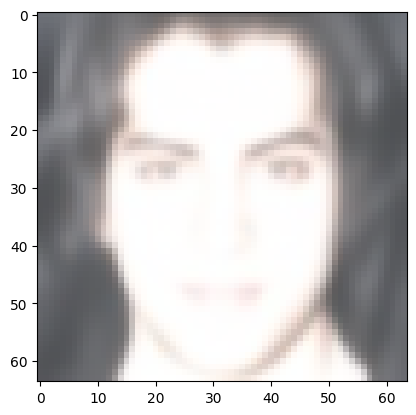

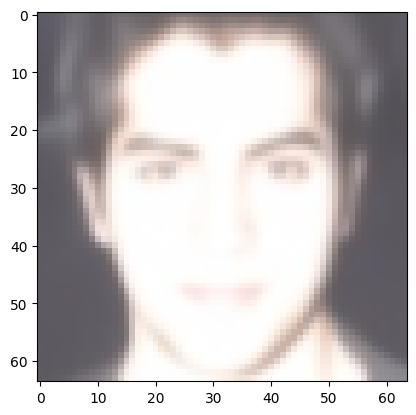

50it [00:03, 13.93it/s]
50it [00:03, 13.96it/s]
50it [01:01,  1.23s/it]


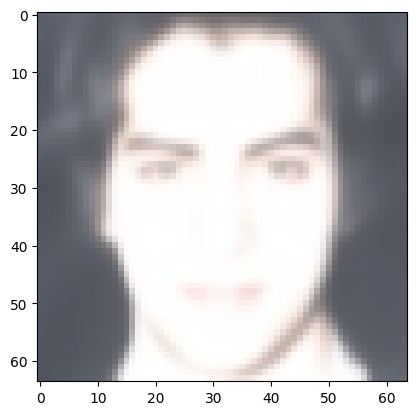

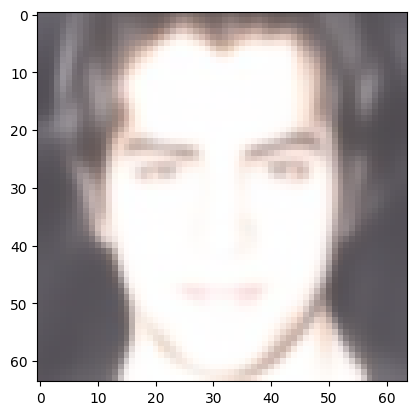

50it [00:03, 13.98it/s]
50it [00:03, 14.23it/s]
50it [01:03,  1.27s/it]


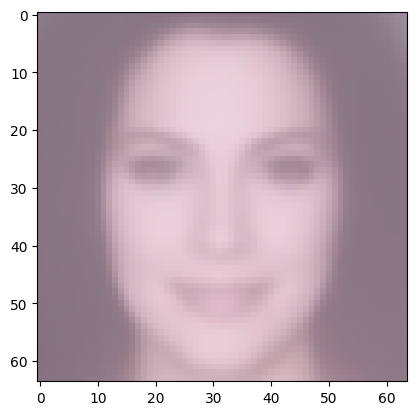

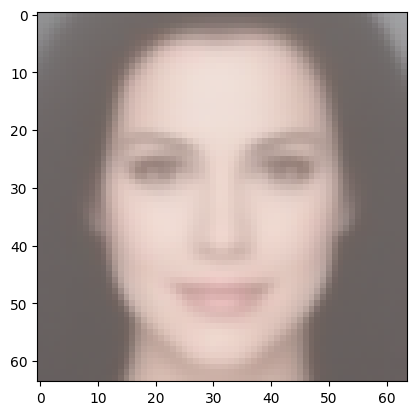

50it [00:03, 14.10it/s]
50it [00:03, 14.22it/s]
50it [00:59,  1.19s/it]


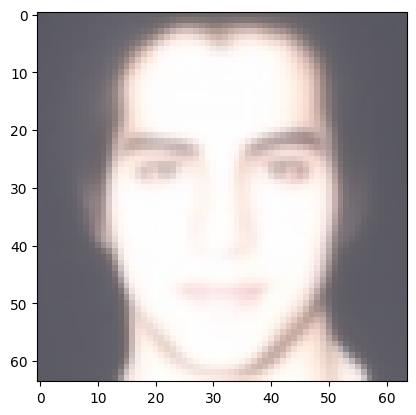

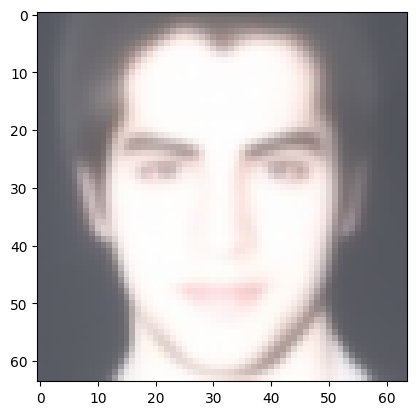

50it [00:03, 14.23it/s]
50it [00:03, 14.17it/s]
50it [01:04,  1.28s/it]


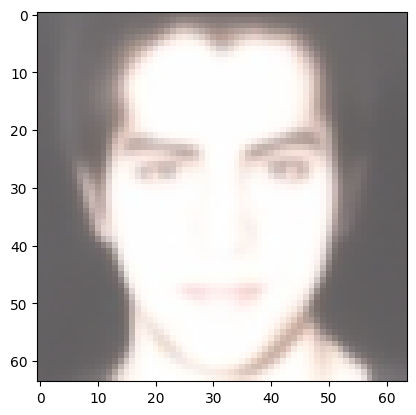

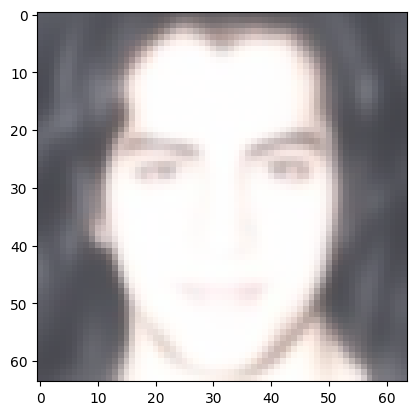

50it [00:03, 14.13it/s]
50it [00:03, 13.99it/s]
50it [01:02,  1.24s/it]


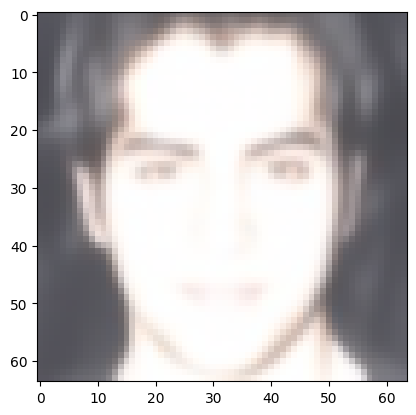

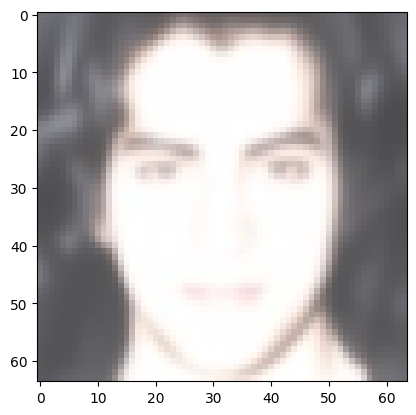

50it [00:03, 14.07it/s]
50it [00:03, 14.20it/s]
50it [01:01,  1.23s/it]


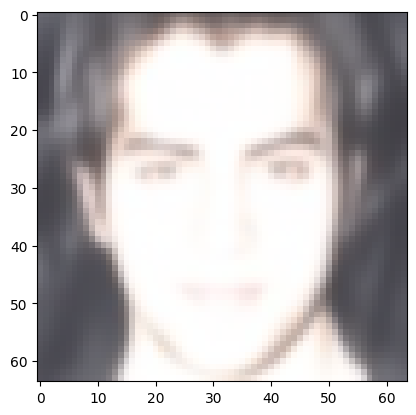

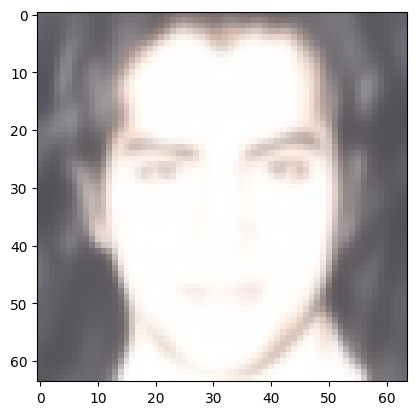

50it [00:03, 14.00it/s]
50it [00:03, 14.07it/s]
50it [00:42,  1.19it/s]


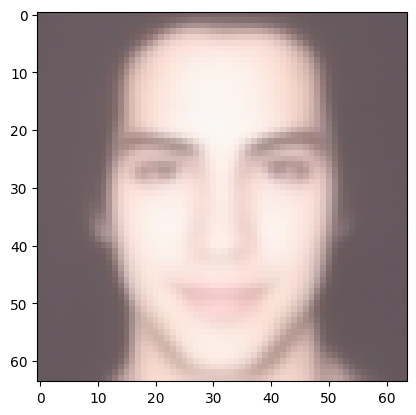

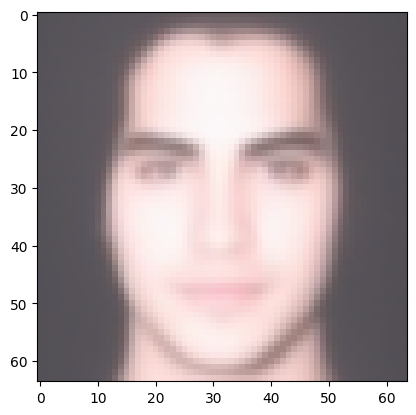

50it [00:03, 14.13it/s]
50it [00:03, 14.01it/s]
50it [00:42,  1.17it/s]


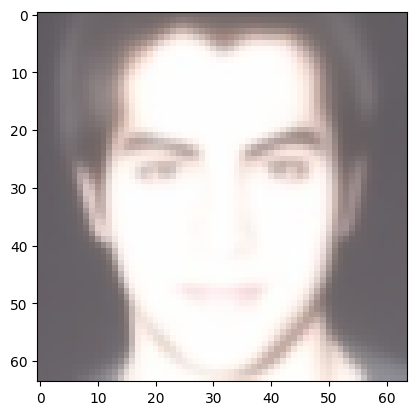

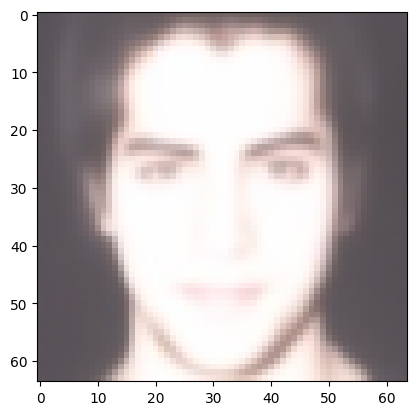

50it [00:03, 14.07it/s]
50it [00:03, 14.11it/s]
50it [00:41,  1.20it/s]


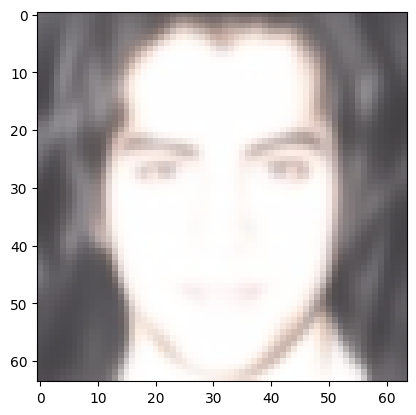

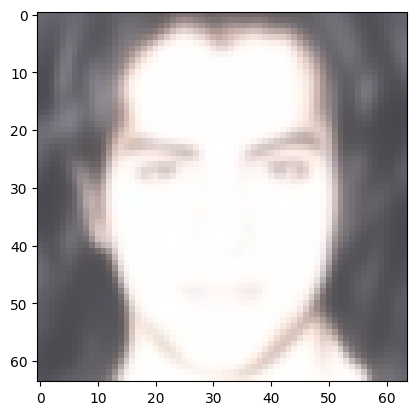

50it [00:03, 13.95it/s]
50it [00:03, 14.18it/s]
50it [00:43,  1.16it/s]


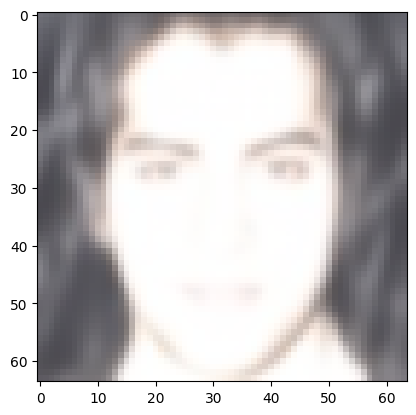

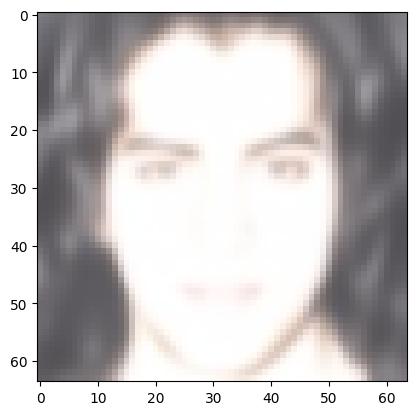

50it [00:03, 14.15it/s]
50it [00:03, 14.14it/s]
50it [00:41,  1.22it/s]


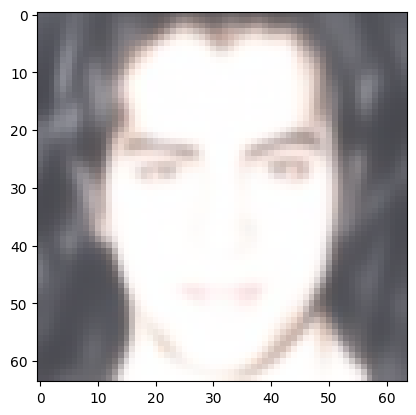

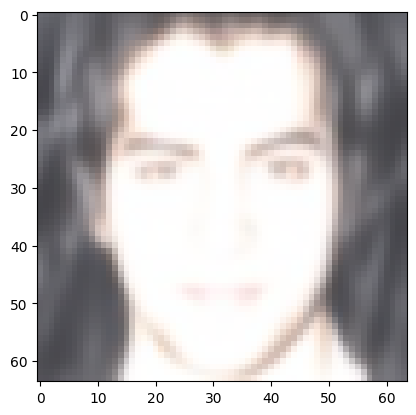

50it [00:03, 14.32it/s]
50it [00:03, 13.94it/s]
50it [01:52,  2.24s/it]


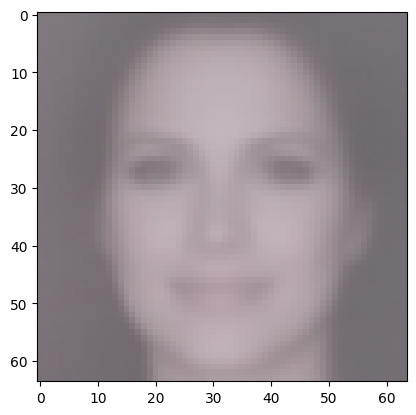

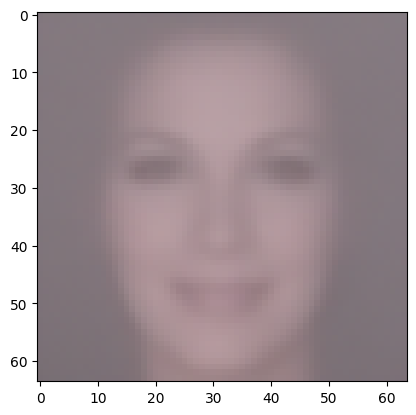

50it [00:03, 14.32it/s]
50it [00:03, 14.30it/s]
50it [01:51,  2.23s/it]


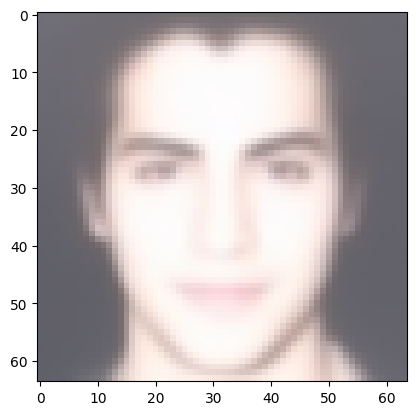

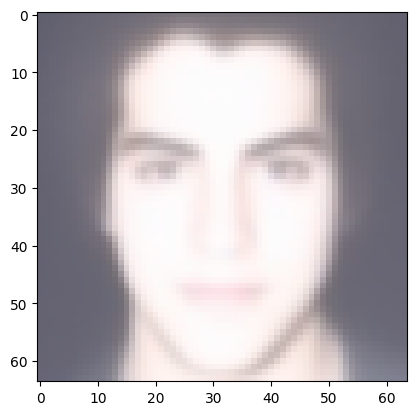

50it [00:03, 14.37it/s]
50it [00:03, 14.23it/s]
50it [01:52,  2.26s/it]


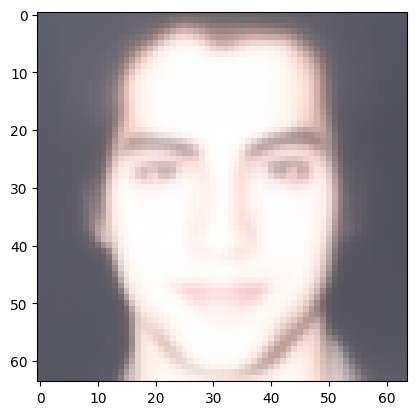

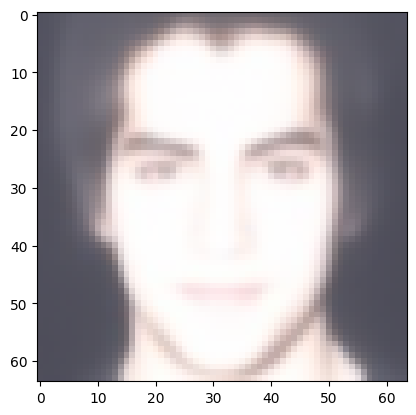

50it [00:03, 14.19it/s]
50it [00:03, 14.24it/s]
50it [01:58,  2.37s/it]


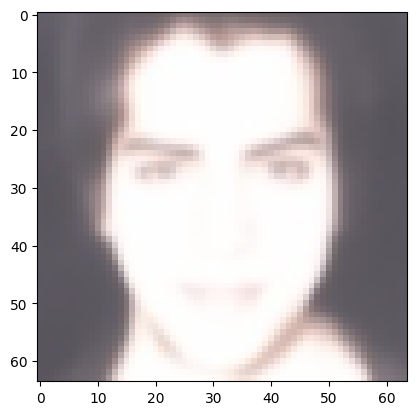

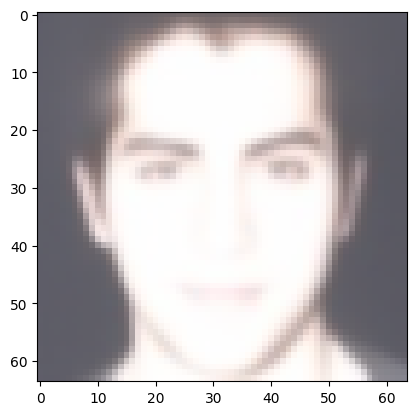

50it [00:03, 14.01it/s]
50it [00:03, 14.23it/s]
50it [01:57,  2.35s/it]


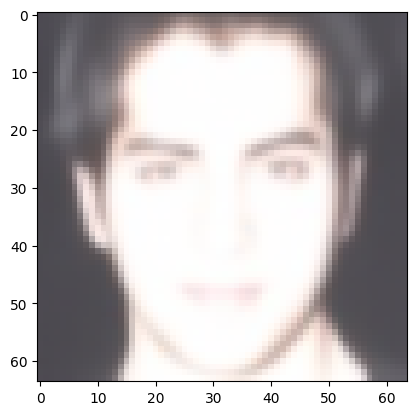

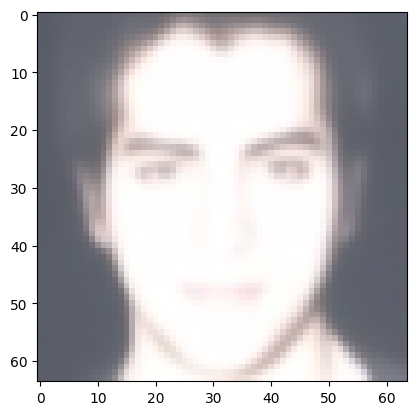

50it [00:03, 14.36it/s]
50it [00:03, 14.20it/s]
50it [01:15,  1.50s/it]


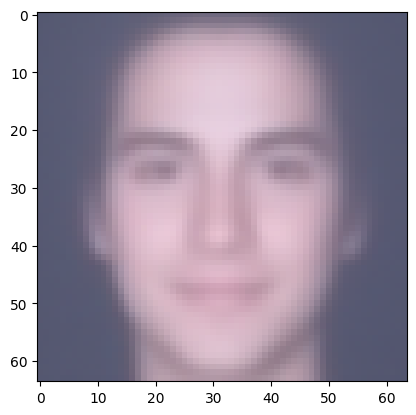

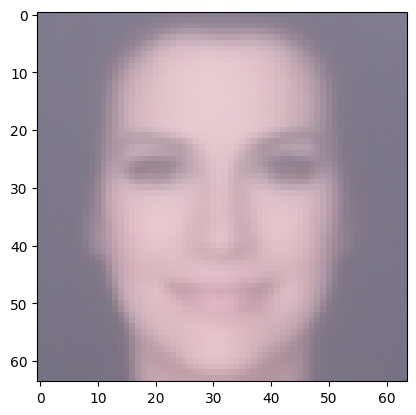

50it [00:03, 14.11it/s]
50it [00:03, 14.17it/s]
50it [01:12,  1.46s/it]


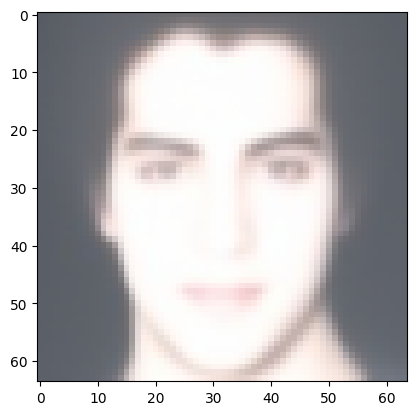

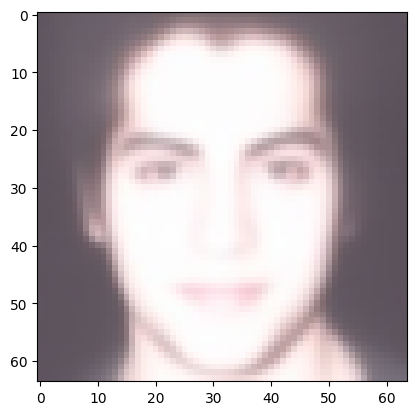

50it [00:03, 14.08it/s]
50it [00:03, 14.26it/s]
50it [01:12,  1.44s/it]


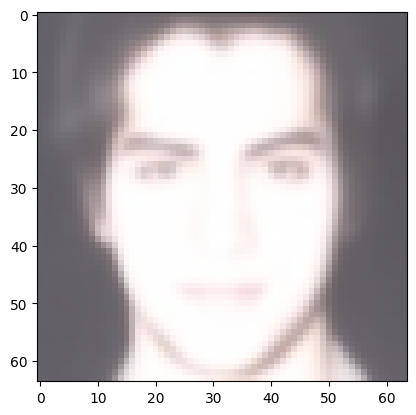

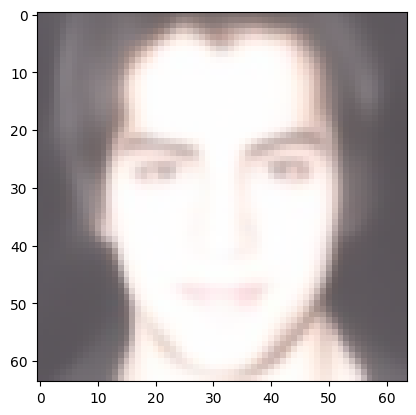

50it [00:03, 14.25it/s]
50it [00:03, 14.00it/s]
50it [01:16,  1.54s/it]


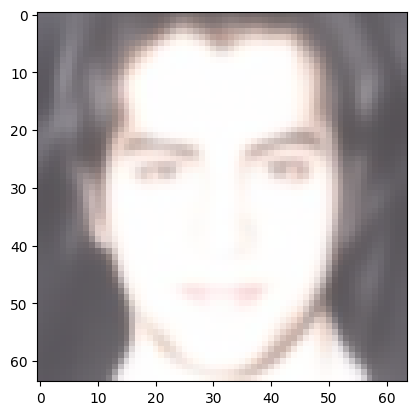

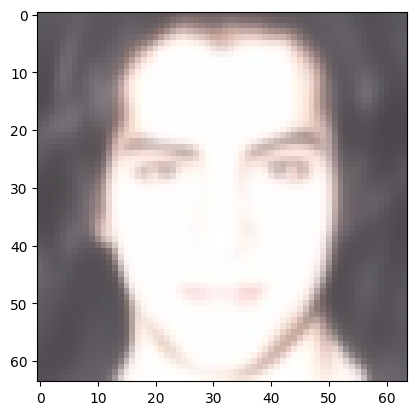

50it [00:03, 14.20it/s]
50it [00:03, 13.68it/s]
50it [01:15,  1.52s/it]


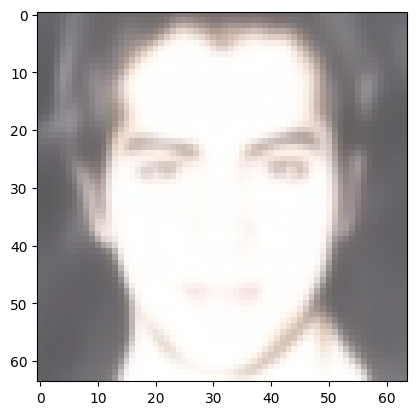

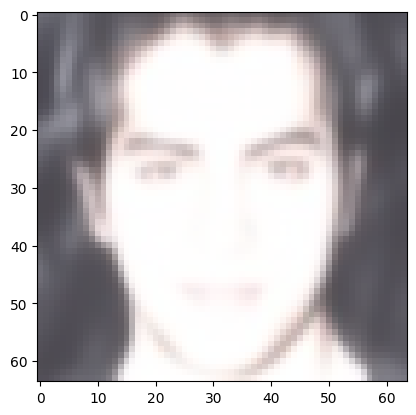

In [52]:
corruptions_list = ["spatter", "gaussian_blur", "glass_blur", "motion_blur", "frost", "snow", "contrast", "masking_vline_random_color", 
                      "elastic_transform", "masking_gaussian"]
severity_list = [1,3,5]
corruptions_list = ["snow"]
severity_list = [5]
transform_resize_down = Resize(64)
transform_resize_up = Resize(512)
number_of_sample  = 2
with torch.no_grad():
    for corruption in corruptions_list:
        for severity in severity_list:
            for k in [3, 20,50,100]:
                for langevin_step in [2, 10, 12, 24]:
                    if k/langevin_step > 9:
                        continue
                    for j, epsilon in enumerate([5e-7, 1e-7, 5e-8, 3e-8, 2e-8]): 
                        try:
                            name = f"/home/bastienvandelft/Projects/DiffBIR/inputs/demo/face/aligned/{corruption}_{severity}_face_512.png"
                            to_tensor = ToTensor()
                            inputs_normalized= PIL.Image.open(name)
                            inputs_normalized_64 = to_tensor(transform_resize_down(inputs_normalized))
                            inputs = (inputs_normalized_64 - 0.5) *2
                            device="cuda:2"
                            inputs = inputs.to(device)
                            
                            results = ODEdit(inputs, spaced_diffusion, net_model,number_of_sample, k, langevin_step, epsilon)
                            
                            for i in range(len(results)):
                                to_save = results[i]/2+0.5
                                plt.imshow(make_grid(to_save.data.cpu()).permute(1,2,0).numpy())
                                plt.show()
                                name = f"/home/bastienvandelft/Projects/ddpm/samples/ODE/new_{corruption}_{severity}_K_{k}_L_{langevin_step}_{j}_64to64_ODE_{i}.png"
                                save_image(to_save,name)
                                to_save = transform_resize_up(to_save)
                                name = f"/home/bastienvandelft/Projects/ddpm/samples/ODE/new_{corruption}_{severity}_K_{k}_L_{langevin_step}_{j}_64to512_ODE_{i}.png"
                                save_image(to_save,name)          
                        except Exception as e:
                            print(e)


In [ ]:
number_of_sample = 2
K = 100
langevin_step = 24
epsilon =2e-8
samples = ODEdit(inputs, net_model, )

In [18]:
# from torchvision.transforms import Resize

# transform_resize_down = Resize(64)
# transform_resize_up = Resize(512)
# for i in range(len(a)):
#     to_save = transform_resize_up(a[i]/2+0.5)
#     name = f"/home/bastienvandelft/Projects/ddpm/samples/SDE/{corruption}_{corruption_severity}_64to512_SDEdit_{i}.png"

# save_image(to_save,name)

In [19]:
# inputs_list = []
# for i in range(1):
#     noise = torch.randn_like(inputs.squeeze()).cpu()
#     mask = torch.from_numpy((np.random.rand(1,noise.shape[1],noise.shape[2])>0.9).repeat(noise.shape[0], axis=0).astype(float)).unsqueeze(0)
#     new_inputs = torch.clamp(mask*noise+(1-mask)*inputs.cpu(), -1,1)
#     new_inputs_normalized = new_inputs / 2 + 0.5
    # # sample_openai = ((openai_0/2)+0.5)
    # psnr_original = compute_psnr(targets_normalized.permute(1,2,0).numpy(), inputs_normalized.permute(1,2,0).numpy(),
    #                              torch.ones_like(inputs).permute(1,2,0).numpy(), data_range=1.)
    # ssim_original = compute_ssim(targets_normalized.permute(1,2,0).numpy(), inputs_normalized.permute(1,2,0).numpy(), 
    #                              torch.ones_like(inputs).permute(1,2,0).numpy())
    # psnr_align, ssim_align = proc_metrics(targets_normalized.permute(1,2,0).numpy(), new_inputs_normalized.permute(1,2,0).numpy())
    # print('psnr_align', psnr_align)
    # print('ssim_align', ssim_align)
    # inputs_list.append(new_inputs)
# newsample = new_inputs.squeeze()
# # newsample = inputs
# # newsample = ((newsample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
# newsample = ((newsample/2)+0.5)
# newsample = make_grid(newsample.cpu().permute(1,2,0).detach()) #.permute(1,2,0)
# plt.imshow(newsample)

In [26]:
### Test Encoding
(sample_tensor_normalized - 0.5)*2
reversing_inputs = inputs.unsqueeze(0).cuda(2) 
reverse_encoding = spaced_diffusion.ddim_reverse_sample_loop_progressive(net_model,reversing_inputs,
                                                                             clip_denoised=True, eta=0.)
ddpm_of_reencoded_tensor = []
with torch.no_grad():
    for dic in tqdm(reverse_encoding):
        ddpm_of_reencoded_tensor.append(dic['sample'].cpu())
\


ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(net_model,[1,3,64,64], 
                                                clip_denoised=True,noise=ddpm_of_reencoded_tensor[-1].cuda(2))
ddpm_of_resampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_resampled_tensor.append(dic['sample'].cpu())

        


100it [00:05, 17.20it/s]
100it [00:05, 16.98it/s]


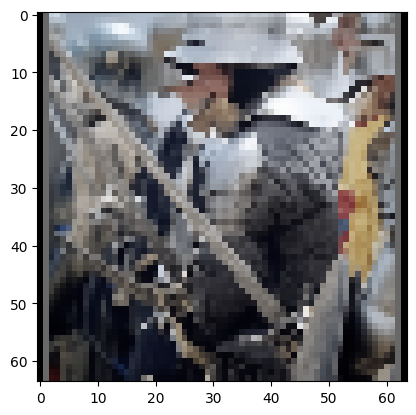

In [27]:
## Reconstruction
newsample = ddpm_of_resampled_tensor[-1]
newsample = ((newsample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
newsample = make_grid(newsample.cpu().detach()).permute(1,2,0)
plt.imshow(newsample)

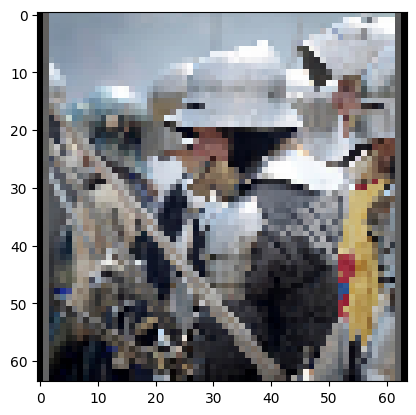

In [24]:
sample = inputs
sample = ((sample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
sample = make_grid(sample.cpu().permute(1,2,0).detach()) #.permute(1,2,0)
plt.imshow(sample)

In [34]:
def ODEdit(inputs,diffusion,  net_model, number_of_sample, K, langevin_step, epsilon):
    reversing_inputs = inputs.unsqueeze(0).cuda(2) 
    reverse_encoding = diffusion.ddim_reverse_sample_loop_progressive(net_model,reversing_inputs,
                                                                                 clip_denoised=True, eta=0.)
    ddpm_of_reencoded_tensor = []
    with torch.no_grad():
        for dic in tqdm(reverse_encoding):
            ddpm_of_reencoded_tensor.append(dic['sample'].cpu())
    
    
    ddpm_imagenet_sample = diffusion.ddim_sample_loop_progressive(net_model,[1,3,64,64], 
                                                    clip_denoised=True,noise=ddpm_of_reencoded_tensor[-1].cuda(2))
    ddpm_of_resampled_tensor = []
    with torch.no_grad():
        for dic in tqdm(ddpm_imagenet_sample):
            ddpm_of_resampled_tensor.append(dic['sample'].cpu())
    
    seed = ddpm_of_reencoded_tensor[-1].cuda(2)
    
    
    ddpm_imagenet_sample = diffusion.ddim_sample_loop_progressive(net_model,[number_of_sample,3,64,64], 
                          clip_denoised=True,noise=seed.repeat(number_of_sample,1,1,1),eta = 0., langevin=True,add_noise=True,temperature=1/2, epsilon=epsilon, K=K, 
                                                                         langevin_step = langevin_step, clip_distance=0.)
    ddpm_of_post_resampled_tensor = []
    with torch.no_grad():
        for dic in tqdm(ddpm_imagenet_sample):
            ddpm_of_post_resampled_tensor.append(dic['sample'].cpu())
    return ddpm_of_post_resampled_tensor[-1]

In [23]:
seed = ddpm_of_reencoded_tensor[-1].cuda(1)
number_of_sample = 2
K = 100
langevin_step = 24
epsilon =2e-8

ddpm_imagenet_sample = spaced_diffusion.ddim_sample_loop_progressive(net_model,[number_of_sample,3,64,64], 
                      clip_denoised=True,noise=seed.repeat(number_of_sample,1,1,1),eta = 0., langevin=True,add_noise=True,temperature=1/2, epsilon=epsilon, K=K, 
                                                                     langevin_step = langevin_step, clip_distance=0.)
ddpm_of_post_resampled_tensor = []
with torch.no_grad():
    for dic in tqdm(ddpm_imagenet_sample):
        ddpm_of_post_resampled_tensor.append(dic['sample'].cpu())

        

50it [01:16,  1.52s/it]


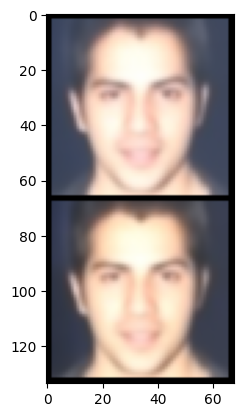

In [25]:
newsample = ddpm_of_post_resampled_tensor[-1]
# newsample = ((newsample + 1) * 127.5).clamp(0, 255).to(torch.uint8)
newsample = ((newsample/2)+0.5)
newsample = make_grid(newsample.cpu().detach(), nrow=1).permute(1,2,0)
plt.imshow(newsample)

In [365]:
from torchvision.transforms import Resize

transform_resize_down = Resize(64)
transform_resize_up = Resize(512)
for i in range(len(ddpm_of_post_resampled_tensor[-1])):
    to_save = transform_resize_up(transform_resize_down(ddpm_of_post_resampled_tensor[-1][i]/2+0.5\
                                                   ))
    name = f"/home/bastienvandelft/Projects/DiffBIR/inputs/demo/face/aligned/{corruption}_{corruption_severity}_face_512_ODEdit_{i}.png"

save_image(to_save,name)